## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [1]:
technical_features = [
    "close_0",
    "close_sp500_0",
    "close_365",
    "close_sp500_365",
    "close__minus_120",
    "close_sp500__minus_120",
    "close__minus_365",
    "close_sp500__minus_365",
    "close__minus_730",
    "close_sp500__minus_730",
    "stock_change_365",
    "stock_change_div_365",
    "sp500_change_365",
    "stock_change__minus_120",
    "sp500_change__minus_120",
    "stock_change__minus_365",
    "sp500_change__minus_365",
    "stock_change__minus_730",
    "sp500_change__minus_730",
    "std__minus_365",
    "std__minus_730",
    "std__minus_120",
]

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [52]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.colors
from plotnine import (
    ggplot,
    geom_histogram,
    aes,
    geom_col,
    coord_flip,
    geom_bar,
    scale_x_discrete,
    geom_point,
    theme,
    element_text,
    geom_boxplot,
    scale_color_manual,
    scale_fill_gradient,
    coord_flip,
    scale_fill_brewer,
    labs,
    guides,
    scale_fill_manual,
)
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from typing import Tuple, Optional, Dict, List
from sklearn.inspection import permutation_importance
from datetime import datetime

In [3]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [4]:
data_set = pd.read_feather("/home/dan1dr/data/financials_against_return.feather")

In [5]:
print(data_set.shape)
data_set.head()

(170483, 144)


,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,...,EBIT_change_2_years,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500
0,A,2005-01-31,0.1695,81.000,-57.000,137.000,2483.0000,5.000,44.000,-5.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.304773
1,NDSN,2005-01-31,0.2248,-3.366,10.663,7.700,62.6220,NaN,NaN,-21.145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387846
2,HURC,2005-01-31,0.3782,0.483,-0.400,2.866,11.3030,0.156,0.854,-0.027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.543440
3,NRT,2005-01-31,1.0517,NaN,NaN,NaN,4.9015,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331322
4,HRL,2005-01-31,0.4880,-12.075,-113.077,83.476,145.2050,NaN,17.084,3.539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218482


In [46]:
data_set[data_set["Ticker"] == "AAPL"]

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,...,EBIT_change_2_years,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500
447,AAPL,2005-03-31,0.3207,406.0,-2432.0,1311.0,7057.0,322.0,-114.0,187.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.489618
2852,AAPL,2005-06-30,0.3356,63.0,305.0,472.0,7526.0,-243.0,61.0,312.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.348821
5409,AAPL,2005-09-30,0.3194,74.0,-429.0,752.0,8261.0,249.0,-68.0,-150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043944
10118,AAPL,2005-12-31,0.4054,283.0,93.0,283.0,8707.0,1117.0,-436.0,-1050.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.384008
12004,AAPL,2006-03-31,0.3133,-141.0,2462.0,-125.0,8226.0,-788.0,470.0,-365.0,...,NaN,0.334104,NaN,2.430769,NaN,-0.057423,NaN,3.154658e+04,NaN,0.947410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207280,AAPL,2019-12-31,0.2696,-25407.0,-13668.0,30516.0,107162.0,-1089.0,2015.0,3347.0,...,0.029474,0.023206,0.119188,-1.179745,-1.279317,0.228510,0.286473,9.128368e+05,8.653736e+05,0.393320
210430,AAPL,2020-03-31,0.1820,-20940.0,9013.0,13311.0,94051.0,-12431.0,5269.0,4433.0,...,-0.007039,0.036717,0.083115,1.616559,-0.891914,0.137297,0.027473,9.474150e+05,9.382286e+05,NaN
215365,AAPL,2020-06-30,0.1881,-19116.0,-5165.0,16271.0,93025.0,2733.0,-2135.0,-339.0,...,-0.011222,0.057224,0.072796,-1.847968,-2.277015,-0.023328,0.124073,1.030571e+06,1.119621e+06,NaN
217685,AAPL,2020-09-30,0.1998,-21357.0,5531.0,20576.0,90943.0,6725.0,1768.0,-4479.0,...,-0.065023,0.055121,0.033585,-1.429230,-2.855441,-0.114603,0.203637,1.355251e+06,7.887174e+05,NaN


Remove these quarters which have less than `minimum_number_of_tickers` tickers:

In [6]:
df_quarter_lengths = (
    data_set.groupby(["execution_date"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)
data_set = pd.merge(data_set, df_quarter_lengths, on=["execution_date"])
data_set = data_set[data_set["count"] >= minimum_number_of_tickers]

In [165]:
data_set.shape

(170483, 145)

In [9]:
data_set.head(20)

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,...,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500,count
0,A,2005-01-31,0.1695,81.000,-57.0000,137.0000,2483.0000,5.000,44.0000,-5.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.304773,1962
1,NDSN,2005-01-31,0.2248,-3.366,10.6630,7.7000,62.6220,NaN,NaN,-21.1450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387846,1962
2,HURC,2005-01-31,0.3782,0.483,-0.4000,2.8660,11.3030,0.156,0.8540,-0.0270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.543440,1962
3,NRT,2005-01-31,1.0517,NaN,NaN,NaN,4.9015,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331322,1962
4,HRL,2005-01-31,0.4880,-12.075,-113.0770,83.4760,145.2050,NaN,17.0840,3.5390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218482,1962
5,HRB,2005-01-31,0.1687,1122.307,-54.0290,-1564.4330,1111.4640,0.000,0.0000,-4.5610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.231248,1962
6,NTAP,2005-01-31,0.1839,20.424,-277.7090,344.6350,1106.4340,15.355,-40.0650,113.5450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.182464,1962
7,HPQ,2005-01-31,0.2855,-508.000,-411.0000,1558.0000,13600.0000,-1143.000,1598.0000,-374.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.311283,1962
8,HOV,2005-01-31,0.3181,127.135,-19.5990,-92.2810,93.2790,-35.960,52.6650,-26.3790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.604859,1962
9,NVDA,2005-01-31,0.3478,13.843,-151.9530,132.2000,670.0450,52.941,-110.3120,-7.0270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.527354,1962


Create the target:

In [7]:
data_set["diff_ch_sp500"] = (
    data_set["stock_change_div_365"] - data_set["sp500_change_365"]
)

data_set.loc[data_set["diff_ch_sp500"] > 0, "target"] = 1
data_set.loc[data_set["diff_ch_sp500"] < 0, "target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [8]:
def get_weighted_performance_of_stocks(df, metric):
    df["norm_prob"] = 1 / len(df)
    return np.sum(df["norm_prob"] * df[metric])


def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert "Not matching train/test"
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending=False)
    data_set = data_set.head(top_n)
    return data_set


# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return (
        "weighted-return",
        get_weighted_performance_of_stocks(top_dataset, "diff_ch_sp500"),
        True,
    )

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [35]:
def split_train_test_by_period(
    data_set, test_execution_date, include_nulls_in_test=False
):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[
        data_set["execution_date"]
        <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit="day")
    ]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters != None:
        train_set = train_set[
            train_set["execution_date"].isin(execution_dates[-n_train_quarters:])
        ]

    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values("date", ascending=False).drop_duplicates(
        "Ticker", keep="first"
    )

    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [36]:
def get_columns_to_remove():
    columns_to_remove = [
        "date",
        "improve_sp500",
        "Ticker",
        "freq",
        "set",
        "close_sp500_365",
        "close_365",
        "stock_change_365",
        "sp500_change_365",
        "stock_change_div_365",
        "stock_change_730",
        "sp500_change_365",
        "stock_change_div_730",
        "diff_ch_sp500",
        "diff_ch_avg_500",
        "execution_date",
        "target",
        "index",
        "quarter",
        "std_730",
        "count",
    ]

    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [37]:
import warnings

warnings.filterwarnings("ignore")


def train_model(train_set, test_set, learning_rate, path_smooth, n_estimators=300):
    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

    eval_result = {}

    objective = "binary"
    metric = "binary_logloss"
    params = {
        "random_state": 1,
        "verbosity": -1,
        "n_jobs": 10,
        "path_smooth": path_smooth,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "objective": objective,
        "metric": metric,
    }

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_test, lgb_train],
        feval=[top_wt_performance],
        callbacks=[lgb.record_evaluation(eval_result=eval_result)],
    )
    return model, eval_result, X_train, X_test

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [38]:
def run_model_for_execution_date(
    execution_date,
    all_results,
    all_predicted_tickers_list,
    all_models,
    n_estimators,
    learning_rate=0.1,
    path_smooth=0,
    include_nulls_in_test=False,
):
    global train_set
    global test_set
    # split the dataset between train and test
    train_set, test_set = split_train_test_by_period(
        data_set, execution_date, include_nulls_in_test=include_nulls_in_test
    )
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model = None
    X_train = None
    X_test = None

    # if both train and test are not empty
    if train_size > 0 and test_size > 0:
        model, evals_result, X_train, X_test = train_model(
            train_set, test_set, learning_rate, path_smooth, n_estimators
        )

        test_set["prob"] = model.predict(X_test)
        predicted_tickers = test_set.sort_values("prob", ascending=False)
        predicted_tickers["execution_date"] = execution_date
        all_results[(execution_date)] = evals_result
        all_models[(execution_date)] = model
        all_predicted_tickers_list.append(predicted_tickers)
    return all_results, all_predicted_tickers_list, all_models, model, X_train, X_test


execution_dates = np.sort(data_set["execution_date"].unique())

This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [187]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    (
        all_results,
        all_predicted_tickers_list,
        all_models,
        model,
        X_train,
        X_test,
    ) = run_model_for_execution_date(
        execution_date,
        all_results,
        all_predicted_tickers_list,
        all_models,
        n_trees,
        include_nulls_in_test=False,
    )
all_predicted_tickers = pd.concat(all_predicted_tickers_list)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000


2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30T00:00:00.000000000
2013-12-30T00:00:00.000000000
2014-03-31T00:00:00.000000000
2014-06-30T00:00:00.000000000
2014-09-30T00:00:00.000000000
2014-12-30

In [188]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df = pd.concat([df, df_tmp])

    df["execution_date"] = df["execution_date"].astype(str)

    return df

In [199]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [200]:
train_results

,binary_logloss,weighted-return,n_trees,execution_date
0,0.657505,0.267845,0,2006-06-30
1,0.639193,0.483940,1,2006-06-30
2,0.619754,0.218716,2,2006-06-30
3,0.601840,0.247316,3,2006-06-30
4,0.585715,0.250948,4,2006-06-30
...,...,...,...,...
35,0.621253,0.431394,35,2020-03-31
36,0.620597,0.487939,36,2020-03-31
37,0.619887,0.487939,37,2020-03-31
38,0.619180,0.487939,38,2020-03-31


In [201]:
test_results_final_tree = test_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")
train_results_final_tree = train_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")

And this are the results:

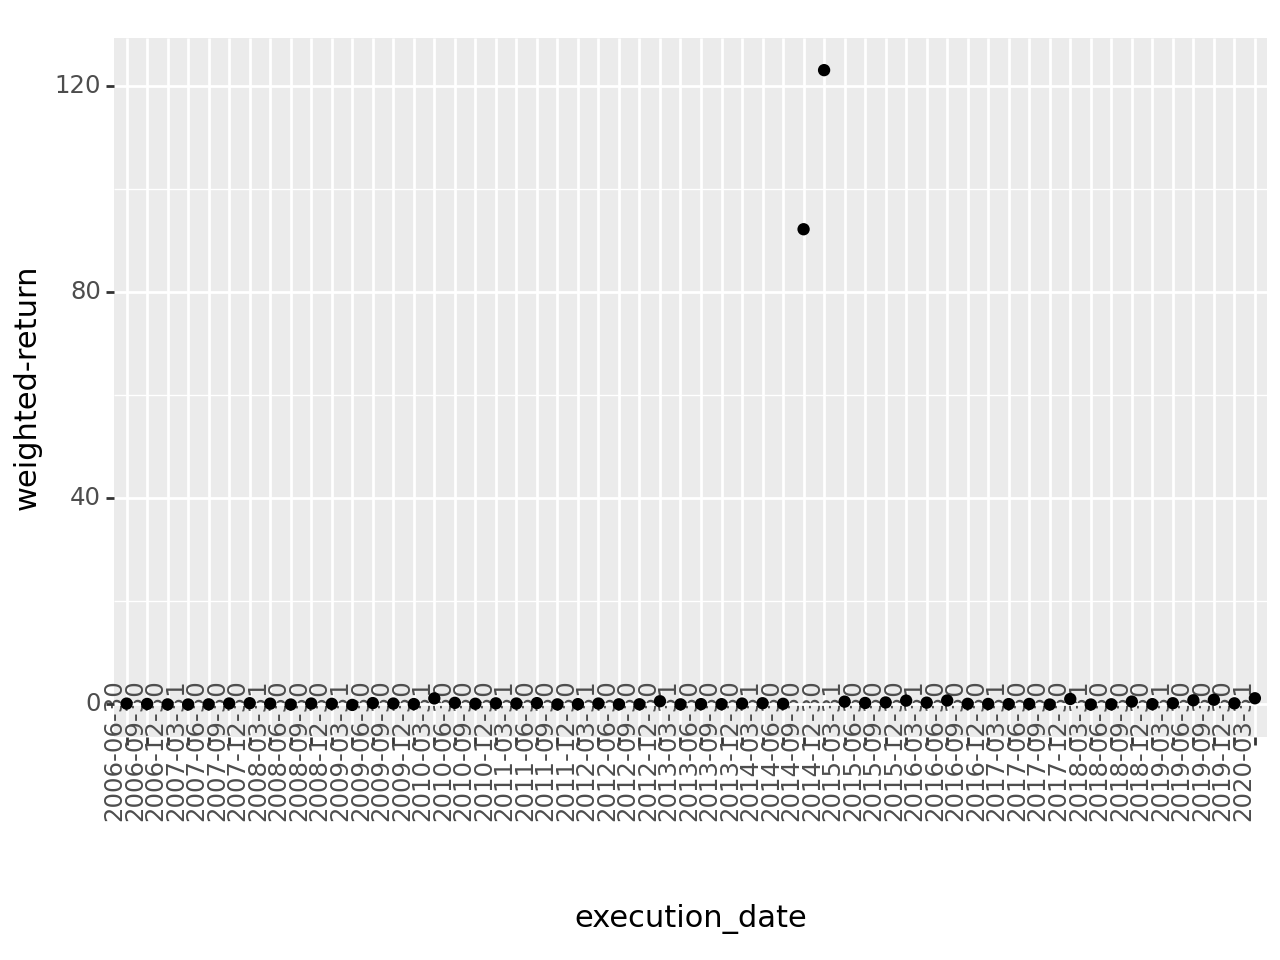

<Figure Size: (640 x 480)>

In [39]:
(
    ggplot(test_results_final_tree)
    + geom_point(aes(x="execution_date", y="weighted-return"))
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

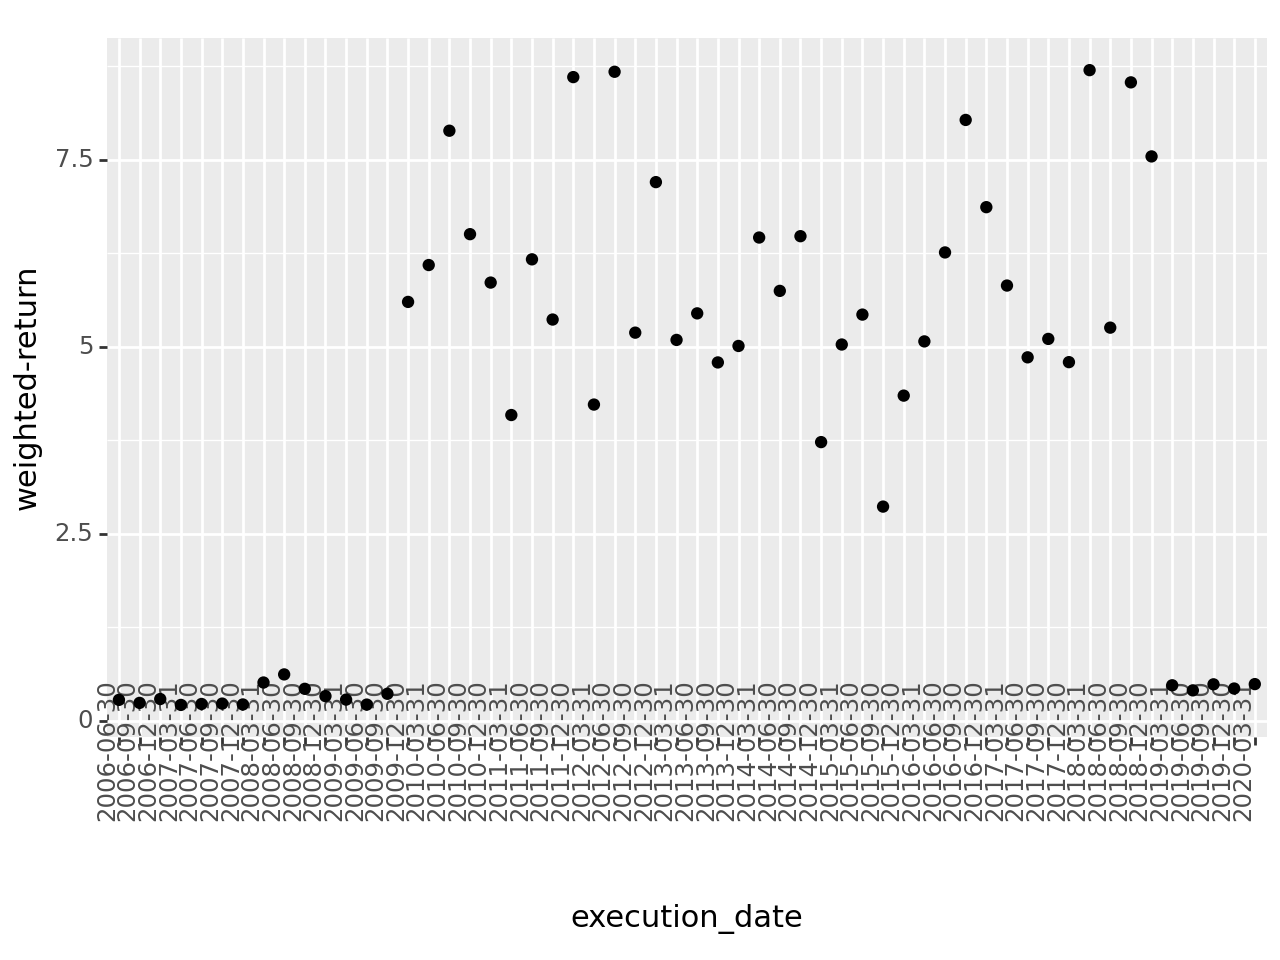

<Figure Size: (640 x 480)>

In [40]:
(
    ggplot(train_results_final_tree)
    + geom_point(aes(x="execution_date", y="weighted-return"))
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [18]:
def draw_feature_importance(model, top=15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame(
        [{"feature": fn[i], "imp": fi[i]} for i in range(len(fi))]
    )
    feature_importance = feature_importance.sort_values("imp", ascending=False).head(
        top
    )
    feature_importance = feature_importance.sort_values("imp", ascending=True)
    plot = (
        ggplot(feature_importance, aes(x="feature", y="imp"))
        + geom_col(fill="lightblue")
        + coord_flip()
        + scale_x_discrete(limits=feature_importance["feature"])
    )
    return plot

# Solution

The solution propose will encompass the following structure:
1. Define baseline: we will create a baseline model for performance comparison, which would be the 500 largest market cap tickers. We could even decide that    the SP500 itself might be the benchmark, but will use the same baseline as the proposed in the solution.

2. Model learning and generalization assessment: evaluate if the model is learning efectively and not overfitting. For that, we will make use of low-levels metrics to optimize the problem and achieve greater top_10 weighted return (top-level). This includes plotting learning curves, adjust hyperparameters and observe the changes.

3. Feature Importance and Data Leakage Inspection: identify key features using SHAP library and check for any potential leakage. Look for anomalies, outliers and perform some feature engineering if needed. Then, re-train the model and re-assess performance.

4. Address additional points for improvement: tackle specific issues and suggestions made in the problem statement, as well as any potential areas for improvement.

## 1. Define baseline

We will use an equal weighted baseline for our approach, i.e. select the top-n market cap and extract the avg return. Another feasible strategy it is to use a market-cap weighted baseline, which will return a number very similar to the sp500 index itself (there are some minor differences if you want to exactly replicate it); even we could just get the sp500 as our baseline as it is our main benchmark here, and it wouldn't make sense if we are not even able to beat the index.

Anyway, as a first approach, we will define the top 500 largest companies by market cap.

In [191]:
test_results_final_tree = test_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")
train_results_final_tree = train_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")

In [192]:
train_results_final_tree.head()

,binary_logloss,weighted-return,n_trees,execution_date
39,0.276797,0.277172,39,2006-06-30
39,0.393084,0.236828,39,2006-09-30
39,0.446241,0.288516,39,2006-12-30
39,0.479211,0.209679,39,2007-03-31
39,0.496369,0.222281,39,2007-06-30


In [193]:
pd.set_option("display.max_columns", None)
all_predicted_tickers.head()

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,ChangeInInventories,CommonStockDividendsPaid,CommonStockNet,ComprehensiveIncome,CostOfGoodsSold,CurrentRatio,DaysSalesInReceivables,DebtIssuanceRetirementNet_minus_Total,DebtEquityRatio,EBIT,EBITMargin,EBITDA,EBITDAMargin,FinancialActivities_minus_Other,GoodwillAndIntangibleAssets,GrossMargin,GrossProfit,IncomeAfterTaxes,IncomeFromContinuousOperations,IncomeFromDiscontinuedOperations,IncomeTaxes,Inventory,InventoryTurnoverRatio,InvestingActivities_minus_Other,LongTermDebt,Long_minus_TermInvestments,Long_minus_termDebtCapital,NetAcquisitionsDivestitures,NetCashFlow,NetChangeInIntangibleAssets,NetChangeInInvestments_minus_Total,NetChangeInLong_minus_TermInvestments,NetChangeInPropertyPlantAndEquipment,NetChangeInShort_minus_termInvestments,NetCommonEquityIssuedRepurchased,NetCurrentDebt,NetIncome,NetIncomeLoss,NetLong_minus_TermDebt,NetProfitMargin,NetTotalEquityIssuedRepurchased,OperatingExpenses,OperatingIncome,OperatingMargin,OtherCurrentAssets,OtherIncome,OtherLong_minus_TermAssets,OtherNon_minus_CashItems,OtherNon_minus_CurrentLiabilities,OtherOperatingIncomeOrExpenses,OtherShareHoldersEquity,Pre_minus_PaidExpenses,Pre_minus_TaxIncome,Pre_minus_TaxProfitMargin,PropertyPlantAndEquipment,ROA_minus_ReturnOnAssets,ROE_minus_ReturnOnEquity,ROI_minus_ReturnOnInvestment,Receivables,ReceiveableTurnover,ResearchAndDevelopmentExpenses,RetainedEarningsAccumulatedDeficit,ReturnOnTangibleEquity,Revenue,SGAExpenses,ShareHolderEquity,Stock_minus_BasedCompensation,TotalAssets,TotalChangeInAssetsLiabilities,TotalCommonAndPreferredStockDividendsPaid,TotalCurrentAssets,TotalCurrentLiabilities,TotalDepreciationAndAmortization_minus_CashFlow,TotalLiabilities,TotalLiabilitiesAndShareHoldersEquity,TotalLongTermLiabilities,TotalLong_minus_TermAssets,TotalNon_minus_CashItems,TotalNon_minus_OperatingIncomeExpense,execution_date,close_0,close_sp500_0,stock_change_365,stock_change_div_365,sp500_change_365,stock_change_730,stock_change_div_730,sp500_change_730,stock_change__minus_120,stock_change_div__minus_120,sp500_change__minus_120,stock_change__minus_365,stock_change_div__minus_365,sp500_change__minus_365,stock_change__minus_730,stock_change_div__minus_730,sp500_change__minus_730,std_730,std__minus_120,std__minus_365,std__minus_730,Market_cap,n_finan_prev_year,Enterprisevalue,EBITDAEV,EBITEV,RevenueEV,CashOnHandEV,PFCF,PE,PB,RDEV,WorkingCapital,ROC,DividendYieldLastYear,EPS_minus_EarningsPerShare_change_1_years,EPS_minus_EarningsPerShare_change_2_years,FreeCashFlowPerShare_change_1_years,FreeCashFlowPerShare_change_2_years,OperatingCashFlowPerShare_change_1_years,OperatingCashFlowPerShare_change_2_years,EBITDA_change_1_years,EBITDA_change_2_years,EBIT_change_1_years,EBIT_change_2_years,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500,count,target,prob
8051,TD,2006-01-31,0.0105,8049.80,-952.120,-6645.170,97038.950,NaN,NaN,NaN,NaN,NaN,5154.850,NaN,1871.680,NaN,NaN,0.000,2.4956,NaN,NaN,NaN,NaN,4285.000,8270.90,NaN,4231.866,2008.800,1977.099,0.0,188.540,NaN,NaN,730.160,6191.820,42595.47,0.2812,-701.880,385.200,NaN,-916.13,NaN,-64.270,NaN,NaN,3541.120,1977.099,1977.090,NaN,56.9069,485.060,3931.900,2171.646,NaN,NaN,NaN,47248.120,NaN,16314.7,NaN,-570.76,NaN,2197.340,63.2461,NaN,0.6002,12.7826,8.9774,NaN,NaN,NaN,10842.760,26.1504,18000.780,1682.290,15831.36,NaN,329411.100,-7594.730,-261.38,229838.800,288633.300,182.540,313579.700,329411.100,24946.390,98114.480,182.540,NaN,2006-06-30,25.483320,1270.20438,0.343890,0.373124,0.183549,0.242549,0.316127,0.007713,0.132029,0.114763,0.014908,-0.124695,-0.158442,-0.062098,-0.372490,-0.436061,-0.101849,0.013489,0.011074,0.009943,0.009740,36619.5306

In [11]:
def merge_against_benchmark(
    metrics_df: pd.DataFrame,
    all_predicted_tickers: pd.DataFrame,
    top_n_market_cap: int = 500,
) -> pd.DataFrame:
    """
    Merges a given metrics DataFrame with a baseline created from the top N tickers by market cap.

    Parameters:
    - metrics_df (pd.DataFrame): A DataFrame containing various metrics including 'execution_date'.
    - all_predicted_tickers (pd.DataFrame): A DataFrame with predicted tickers, including their
      'execution_date', 'Market_cap', and performance relative to the S&P 500 ('diff_ch_sp500').
    - top_n_market_cap (int): The number of top tickers to consider based on market cap (default is 500).

    Returns:
    - pd.DataFrame: The merged DataFrame containing both the original metrics and the baseline for comparison.
    """

    # Sorting and ranking the tickers based on market cap
    all_predicted_tickers = all_predicted_tickers.sort_values(
        ["execution_date", "Market_cap"], ascending=False
    )  # = False applies to both cols
    all_predicted_tickers["rank"] = all_predicted_tickers.groupby(
        ["execution_date"]
    ).cumcount()
    top_tickers = all_predicted_tickers[
        all_predicted_tickers["rank"] <= top_n_market_cap
    ]

    # Calculate the baseline
    baseline = (
        top_tickers.groupby(["execution_date"])["diff_ch_sp500"].mean().reset_index()
    )
    baseline = baseline.rename(columns={"diff_ch_sp500": "diff_ch_sp500_baseline"})
    baseline["execution_date"] = baseline["execution_date"].astype(str)

    metrics_df = pd.merge(metrics_df, baseline, on="execution_date")

    return metrics_df

In [195]:
test_results_final_tree = merge_against_benchmark(
    test_results_final_tree, all_predicted_tickers
)
test_results_final_tree.head()

,binary_logloss,weighted-return,n_trees,execution_date,diff_ch_sp500_baseline
0,0.759610,0.099404,39,2006-06-30,0.049213
1,0.730303,0.035528,39,2006-09-30,0.067796
2,0.715078,-0.052195,39,2006-12-30,0.068473
3,0.710833,-0.067471,39,2007-03-31,0.048029
4,0.711701,-0.045395,39,2007-06-30,0.077166


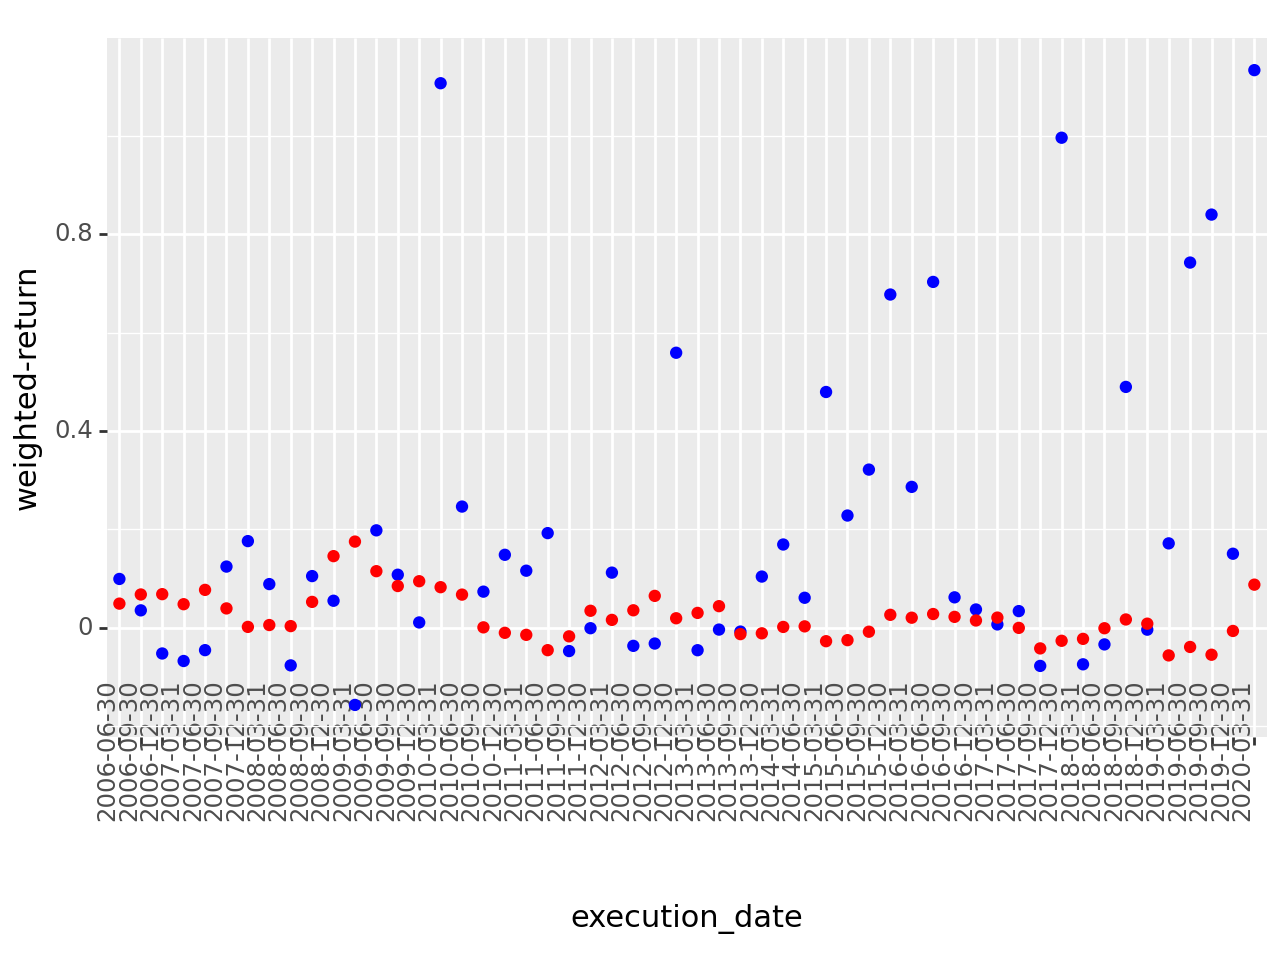

<Figure Size: (640 x 480)>

In [193]:
(
    ggplot(
        test_results_final_tree[test_results_final_tree["weighted-return"] < 10],
        aes(x="execution_date"),
    )
    + geom_point(aes(y="weighted-return"), colour="blue")
    + geom_point(aes(y="diff_ch_sp500_baseline"), colour="red")
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

In [198]:
print(f"Mean for model: {test_results_final_tree['weighted-return'].mean()}")
print(
    f"Mean for baseline: {test_results_final_tree['diff_ch_sp500_baseline'].mean()}\n"
)

print(f"Median for model: {test_results_final_tree['weighted-return'].median()}")
print(
    f"Median for baseline: {test_results_final_tree['diff_ch_sp500_baseline'].median()}\n"
)

Mean for model: 4.029023035251342
Mean for baseline: 0.022159133577893696

Median for model: 0.10471844503860958
Median for baseline: 0.015525563344158869



Our model does 38 pts better in average and the median is 9 points better, maybe too optimistic to be true. Let's explore what could be happening more deeply:

## 2. Model learning and generalization assessment

In machine learning, the ultimate goal for the model is to try to reduce the error function as much as possible. While this might be positive, sometimes the metric being optimized is not necessarily our best metric based on the business problem we are tackling. In this light, there exists a range of different metrics closer to the model or business, which might be interesting to keep in mind and be diligent to know in which area we are trying to optimize. We can denominate that "pyramid," referring to how close we are with respect to the model, e.g., low-level if we are closer to the model, or high-level if we abstract enough from the model and we are closer to the business.

- Low-Level Metrics (Closest to the Model):
    - Log Loss (Binary Cross-Entropy): A standard metric for binary classification models. It measures the model's ability to assign high probabilities to the correct class. It's sensitive to the confidence of the predictions. This sensitivity is crucial in probabilistic models like yours.
    - Alternatives to Log Loss:
        - Mean Squared Error (MSE): Typically used for regression but can be adapted for classification. It penalizes large errors more heavily.
        - Hinge Loss: Common in SVM models; it's more about margin maximization, less sensitive to probabilistic outputs.
- Mid-Level Metrics (Balancing Model and Business Objectives):
    - Accuracy: The proportion of correctly predicted instances. It's intuitive but can be misleading in imbalanced datasets.
    - Precision and Recall: Precision measures the correctness achieved in positive prediction, while recall measures how many actual positives were correctly identified.
    - F1-Score: The harmonic mean of precision and recall, useful when you need a balance between precision and recall.
- High-Level Metrics (Direct Business Impact):
    - Top 10 Weighted Return: Your primary metric, directly aligned with your business objective (portfolio performance).
    - Sharpe Ratio: Measures risk-adjusted return; it could be a supplementary metric for evaluating the effectiveness of the investment strategy.

For visualization, I've illustrated a basic graph the following:

<img src="images/pyramid_metrics.png" width="800" height="550">


Let's try to evaluate if the model is learning correctly plotting the curves for each tree. We want to calculate the percentage difference of the logloss metric at each tree compared to the first one, to understand if model is improving, overfitting, or underperforming as more trees are added.

In [12]:
def compute_learning_rate(set_: str, all_results: dict) -> pd.DataFrame:
    """
    Calculate the normalized learning rates for the model

    Parameters:
    - set_ (str): The dataset type ('training' or 'valid_0').
    - all_results (dict): Dictionary containing training results for each execution date.

    Returns:
    - pd.DataFrame: DataFrame with normalized learning rates, including execution dates and tree categories.
    """

    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[date][set_])
        df_tmp["n_trees"] = range(len(df_tmp))
        df_tmp["execution_date"] = date
        df = pd.concat([df, df_tmp])

    # Calculate the % diff respect to first tree
    df["first_tree_logloss"] = df.groupby(["execution_date"])[
        "binary_logloss"
    ].transform("first")
    df[f"normalized_learning_{set_}"] = (
        df["binary_logloss"] - df["first_tree_logloss"]
    ) / df["first_tree_logloss"]
    df = df.drop(columns="first_tree_logloss")

    return df

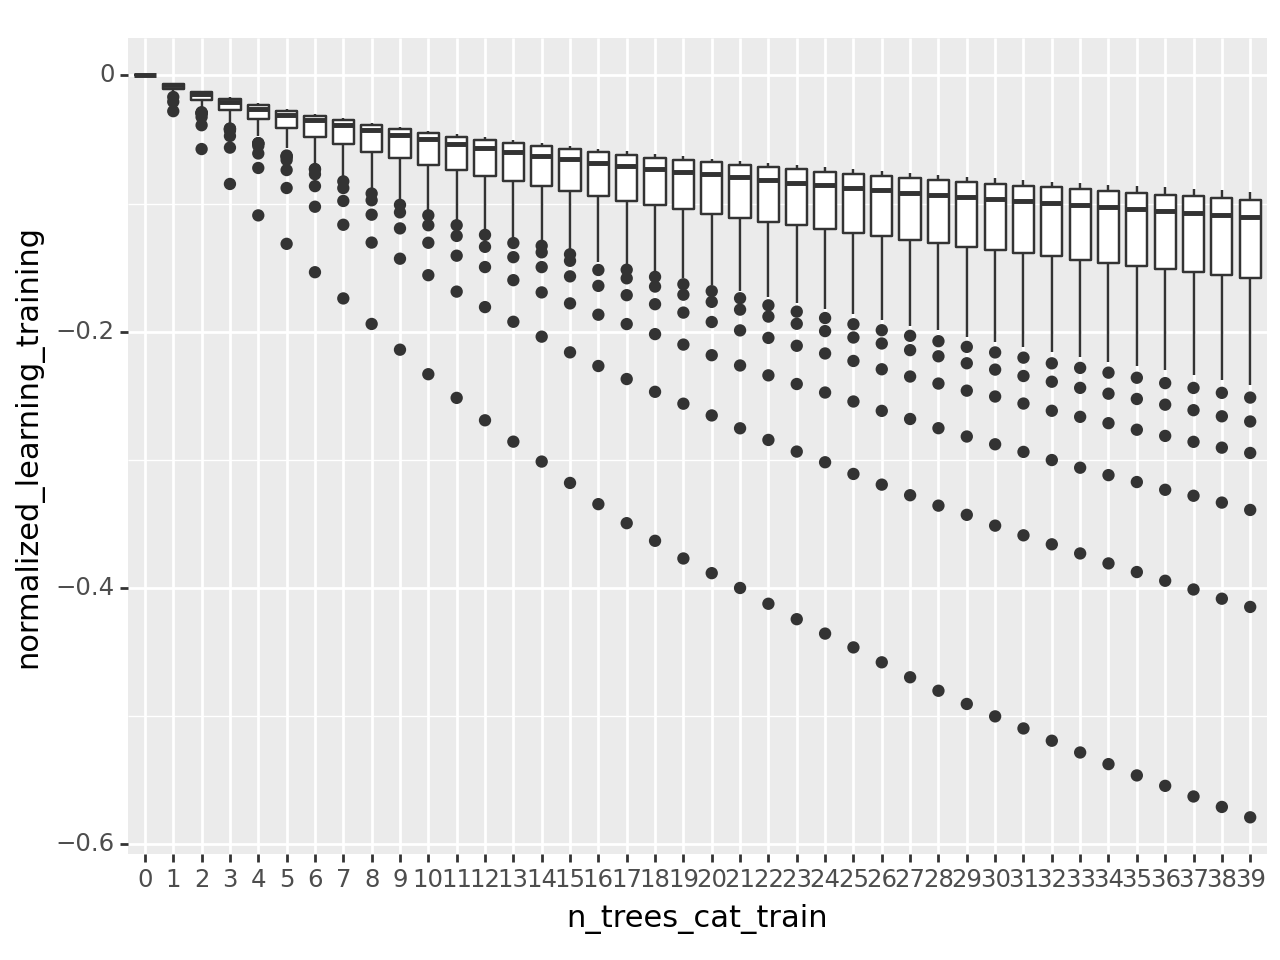

<Figure Size: (640 x 480)>

In [223]:
learning_rates_train = compute_learning_rate("training", all_results)
learning_rates_test = compute_learning_rate("valid_0", all_results)

# Convert 'n_trees' to a categorical variable for better plotting
learning_rates_train["n_trees_cat_train"] = pd.Categorical(
    learning_rates_train["n_trees"],
    categories=sorted(learning_rates_train["n_trees"].unique()),
)
learning_rates_test["n_trees_cat_test"] = pd.Categorical(
    learning_rates_test["n_trees"],
    categories=sorted(learning_rates_test["n_trees"].unique()),
)

# Merging training and validation learning rates for comparison
learning_rates = pd.merge(
    learning_rates_test[
        ["n_trees", "n_trees_cat_test", "normalized_learning_valid_0", "execution_date"]
    ],
    learning_rates_train[
        [
            "n_trees",
            "n_trees_cat_train",
            "normalized_learning_training",
            "execution_date",
        ]
    ],
    on=["execution_date", "n_trees"],
)
ggplot(learning_rates, aes(x="n_trees_cat_train")) + geom_boxplot(
    aes(y="normalized_learning_training")
)

Model learning OK for each additional n_tree passed. Let's compare in validation:

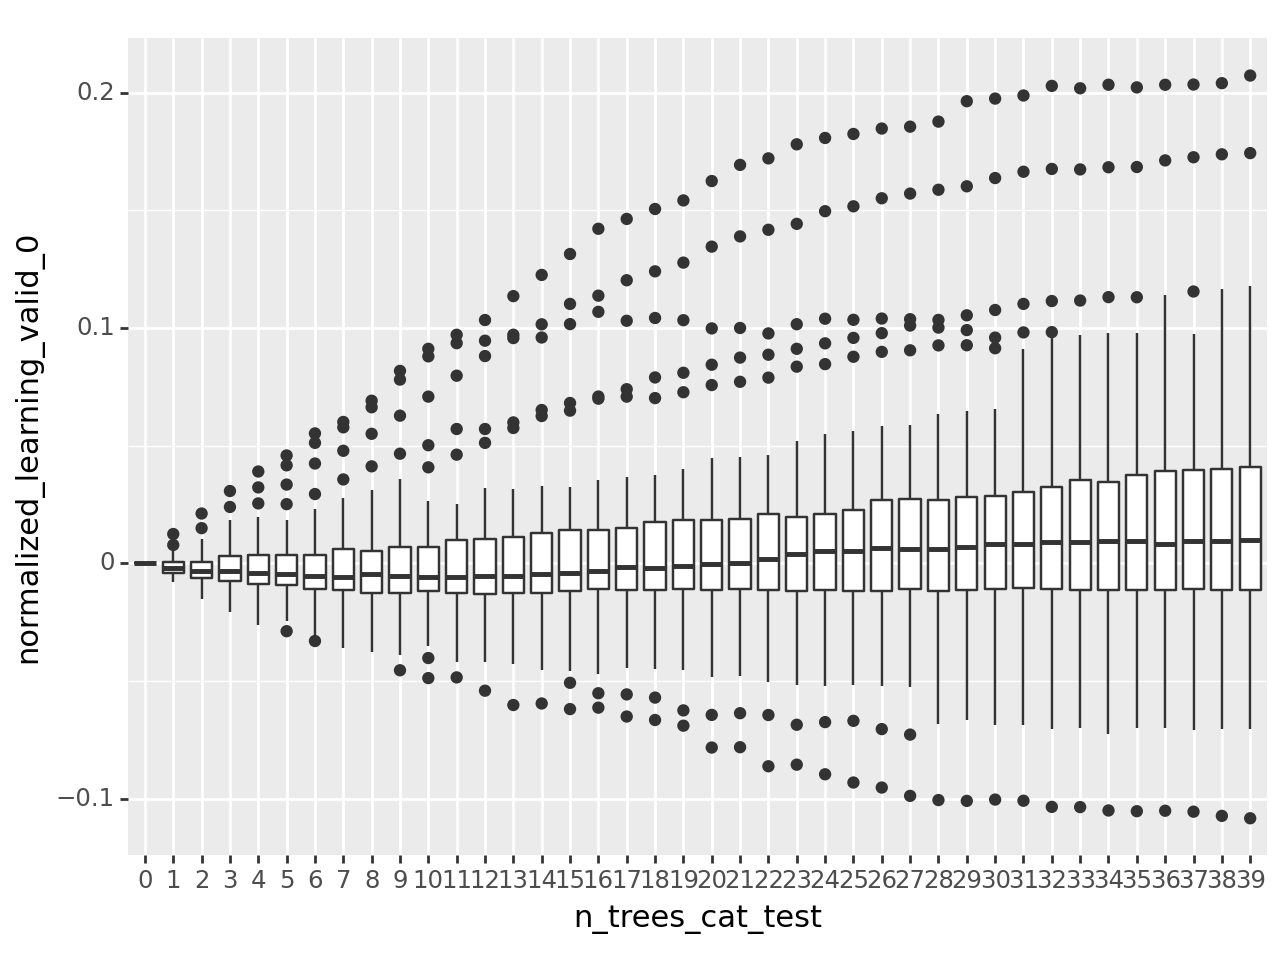

<Figure Size: (640 x 480)>

In [224]:
ggplot(learning_rates, aes(x="n_trees_cat_test")) + geom_boxplot(
    aes(y="normalized_learning_valid_0")
)

We see the model seems to have a slightly decreasing tren until tree 20th, since there the logloss start increasing again. Let's zoom in for only first 20 n_trees then:

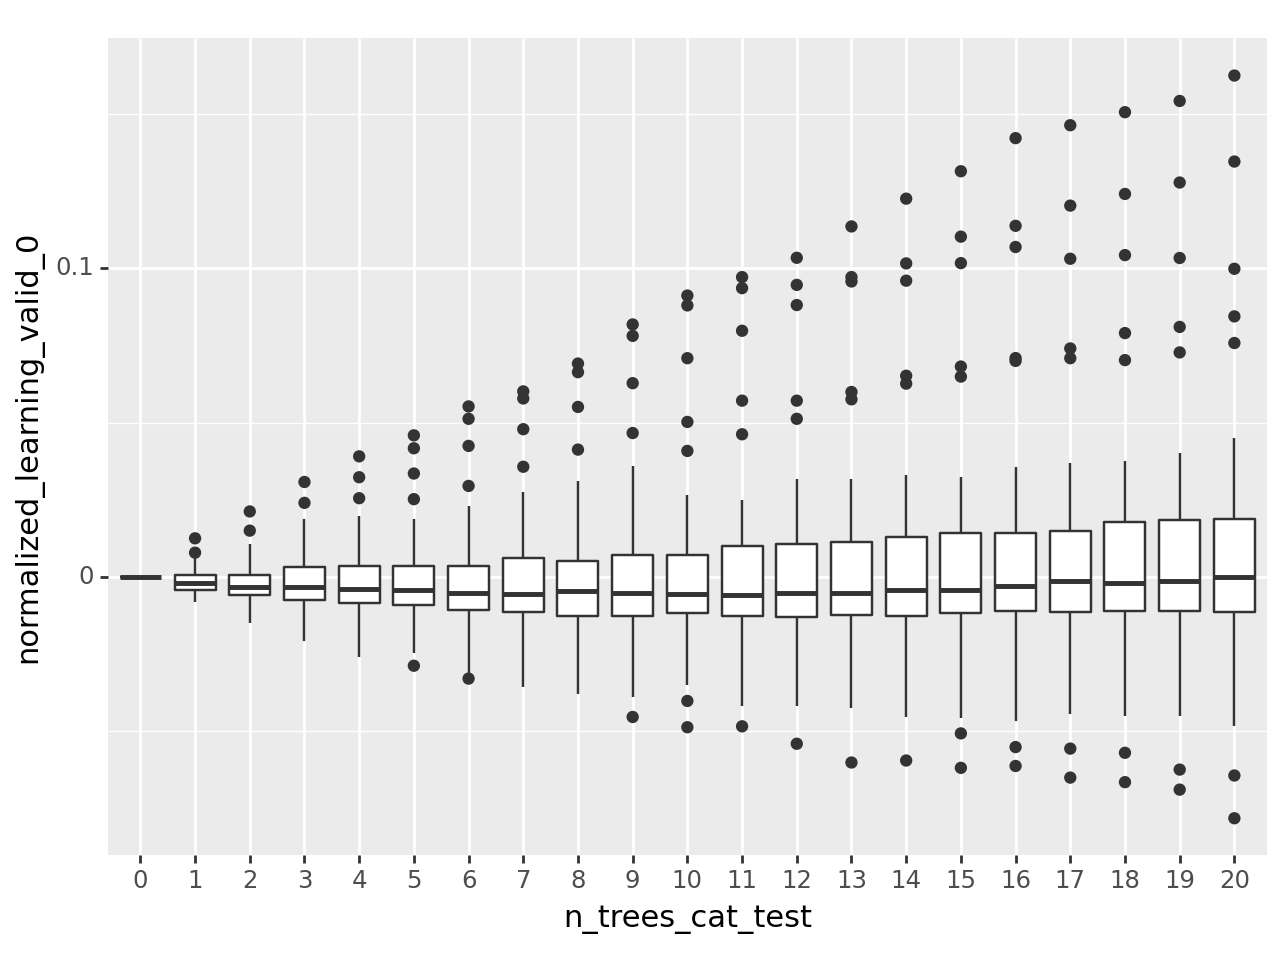

<Figure Size: (640 x 480)>

In [226]:
ggplot(
    learning_rates[learning_rates["n_trees"] <= 20], aes(x="n_trees_cat_test")
) + geom_boxplot(aes(y="normalized_learning_valid_0"))

Minimum loss obtained around tree = 10. From that point, it again increases. That might be happening for several reason, first let's try to play a bit with hyperparameters:

- learning_rate: let's reduce it in order to make smaller steps
- n_estimators: n_trees
- path_smoth: introduces regularization term (smoother boundaries)
- num_leaves: max. leaves per tree

In [39]:
import warnings

warnings.filterwarnings("ignore")


def train_model(train_set, test_set, params, n_estimators=300):
    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

    eval_result = {}

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_test, lgb_train],
        feval=[top_wt_performance],
        callbacks=[lgb.record_evaluation(eval_result=eval_result)],
    )
    return model, eval_result, X_train, X_test

In [26]:
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "n_estimators": 20,
    "learning_rate": 0.05,
    "path_smooth": 0.1,
    "objective": "binary",
    "metric": "binary_logloss",
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}


for execution_date in execution_dates:
    print(execution_date)
    (
        all_results,
        all_predicted_tickers_list,
        all_models,
        model,
        X_train,
        X_test,
    ) = run_model_for_execution_date(
        execution_date,
        all_results,
        all_predicted_tickers_list,
        all_models,
        n_trees,
        params,
        False,
    )
all_predicted_tickers = pd.concat(all_predicted_tickers_list)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

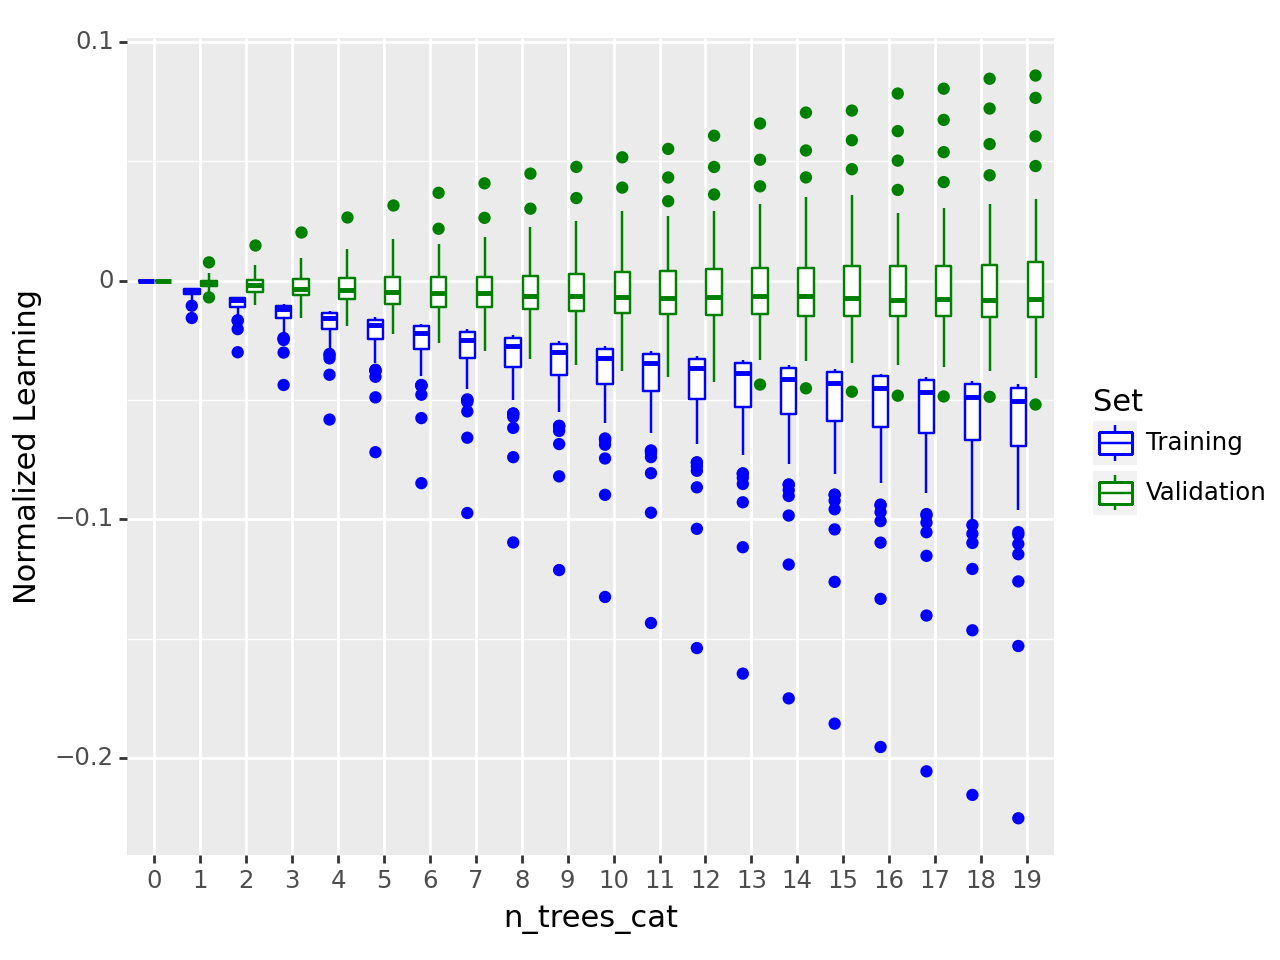

In [27]:
learning_rates_train = compute_learning_rate("training", all_results)
learning_rates_test = compute_learning_rate("valid_0", all_results)

# Filter for n_trees <= 20
learning_rates_train = learning_rates_train[learning_rates_train["n_trees"] <= 20]
learning_rates_test = learning_rates_test[learning_rates_test["n_trees"] <= 20]

# Convert 'n_trees' to a categorical variable for better plotting
learning_rates_train = learning_rates_train[
    ["n_trees", "normalized_learning_training", "execution_date"]
]
learning_rates_test = learning_rates_test[
    ["n_trees", "normalized_learning_valid_0", "execution_date"]
]

# Rename columns for merging
learning_rates_train.rename(
    columns={"normalized_learning_training": "Normalized Learning"}, inplace=True
)
learning_rates_test.rename(
    columns={"normalized_learning_valid_0": "Normalized Learning"}, inplace=True
)

learning_rates_train["Set"] = "Training"
learning_rates_test["Set"] = "Validation"

learning_rates_combined = pd.concat([learning_rates_train, learning_rates_test])


learning_rates_combined["n_trees_cat"] = pd.Categorical(
    learning_rates_combined["n_trees"],
    categories=sorted(learning_rates_combined["n_trees"].unique()),
)

# Plotting
plot = (
    ggplot(
        learning_rates_combined,
        aes(x="n_trees_cat", y="Normalized Learning", color="Set"),
    )
    + geom_boxplot()
    + scale_color_manual(values=["blue", "green"])
)

print(plot)

Seems to improve, let's try with an stronger regularization also:

In [28]:
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "n_estimators": 20,
    "learning_rate": 0.01,
    "path_smooth": 0.3,
    "objective": "binary",
    "metric": "binary_logloss",
}

all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    (
        all_results,
        all_predicted_tickers_list,
        all_models,
        model,
        X_train,
        X_test,
    ) = run_model_for_execution_date(
        execution_date,
        all_results,
        all_predicted_tickers_list,
        all_models,
        n_trees,
        params,
        False,
    )
all_predicted_tickers = pd.concat(all_predicted_tickers_list)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

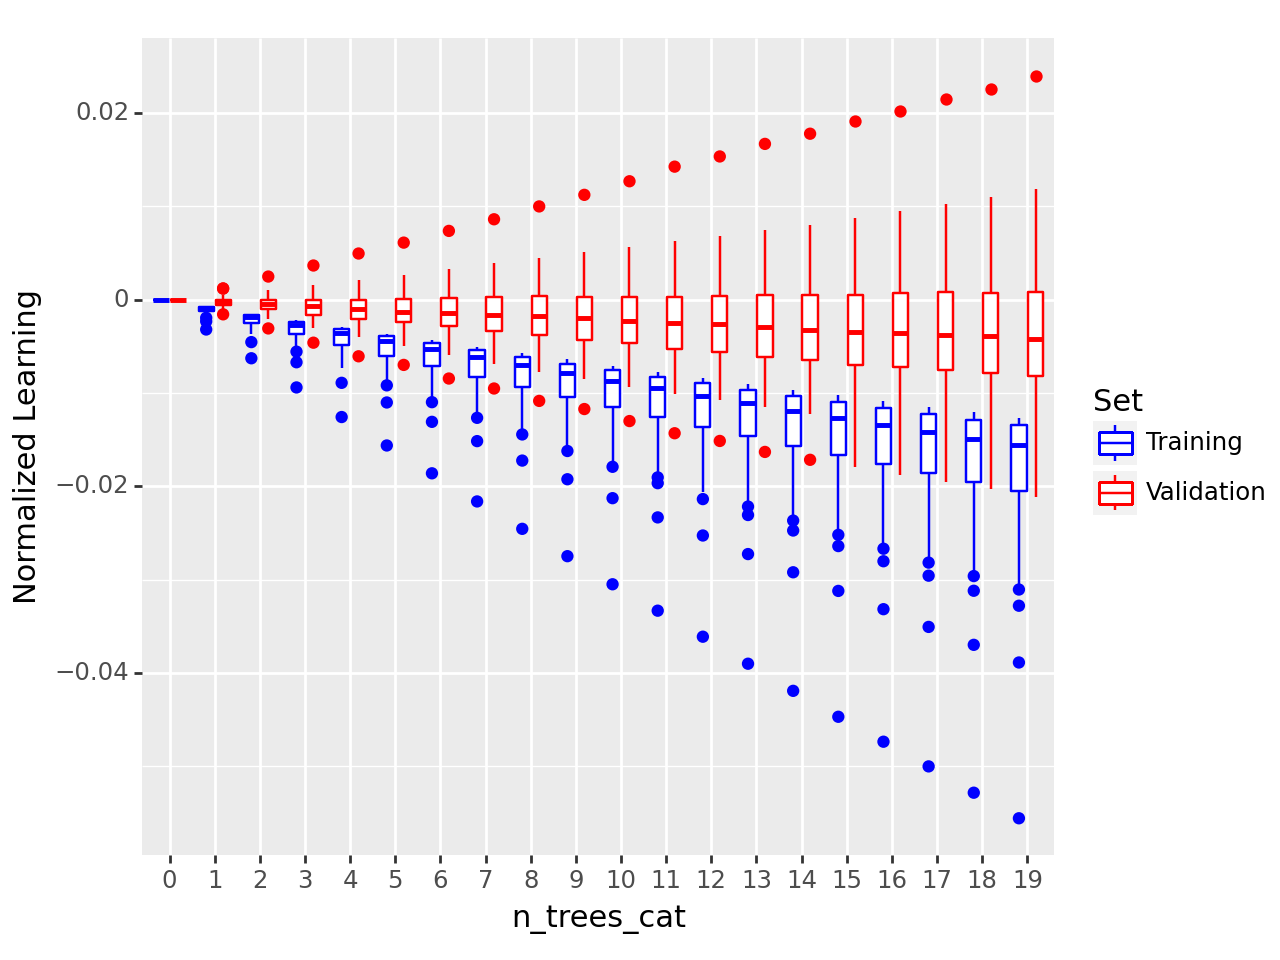

In [29]:
learning_rates_train = compute_learning_rate("training", all_results)
learning_rates_test = compute_learning_rate("valid_0", all_results)

learning_rates_train = learning_rates_train[learning_rates_train["n_trees"] <= 20]
learning_rates_test = learning_rates_test[learning_rates_test["n_trees"] <= 20]

learning_rates_train = learning_rates_train[
    ["n_trees", "normalized_learning_training", "execution_date"]
]
learning_rates_test = learning_rates_test[
    ["n_trees", "normalized_learning_valid_0", "execution_date"]
]

learning_rates_train.rename(
    columns={"normalized_learning_training": "Normalized Learning"}, inplace=True
)
learning_rates_test.rename(
    columns={"normalized_learning_valid_0": "Normalized Learning"}, inplace=True
)

learning_rates_train["Set"] = "Training"
learning_rates_test["Set"] = "Validation"

learning_rates_combined = pd.concat([learning_rates_train, learning_rates_test])

learning_rates_combined["n_trees_cat"] = pd.Categorical(
    learning_rates_combined["n_trees"],
    categories=sorted(learning_rates_combined["n_trees"].unique()),
)

# Plotting
plot = (
    ggplot(
        learning_rates_combined,
        aes(x="n_trees_cat", y="Normalized Learning", color="Set"),
    )
    + geom_boxplot()
    + scale_color_manual(values=["blue", "red"])
)

print(plot)

Yep, even better. Enough fine-tuning as we do not want to overfit on training set.
Keep and eye on lambda rank and ndcg

## 3. Feature importance and Data Leakage

In [40]:
import pandas as pd
import lightgbm as lgb
from typing import Tuple, Optional, Dict, List
from lightgbm import LGBMClassifier
from sklearn.inspection import permutation_importance


def train_model(
    train_set: pd.DataFrame, test_set: pd.DataFrame, params: Dict
) -> Tuple[LGBMClassifier, Dict, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Trains the LightGBM model and computes feature importance.

    Parameters:
    - train_set (pd.DataFrame): Training dataset.
    - test_set (pd.DataFrame): Testing dataset.
    - params (Dict): Parameters for the LightGBM model.

    Returns:
    - Tuple[LGBMClassifier, Dict, pd.DataFrame, pd.DataFrame, pd.DataFrame]: Trained model, evaluation results, training features, testing features, feature importance dataframe.
    """
    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    clf = LGBMClassifier(**params)
    model = clf.fit(
        X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="binary_logloss"
    )

    # Compute feature importance
    pi = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=0)
    feature_names = X_test.columns
    df_feature_importance = pd.DataFrame(
        {"importance": pi.importances_mean, "feature": feature_names}
    )

    return model, X_train, X_test, df_feature_importance

In [41]:
def run_model_for_execution_date(
    execution_date: str,
    all_results: Dict,
    all_predicted_tickers_list: List[pd.DataFrame],
    all_models: Dict,
    all_feature_importance: pd.DataFrame,
    params: Dict,
    include_nulls_in_test: bool = False,
) -> Tuple[
    Dict,
    List[pd.DataFrame],
    Dict,
    LGBMClassifier,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
]:
    """
    Runs the model for a specific execution date and computes feature importance.

    Parameters:
    - execution_date (str): The execution date for the model.
    - all_results (Dict): Dictionary to store all results.
    - all_predicted_tickers_list (List[pd.DataFrame]): List to store all predicted tickers.
    - all_models (Dict): Dictionary to store all models.
    - all_feature_importance (pd.DataFrame): DataFrame to store all feature importances.
    - params (Dict): Parameters for the LightGBM model.
    - include_nulls_in_test (bool): Flag to include nulls in the test set.

    Returns:
    - Tuple[Dict, List[pd.DataFrame], Dict, LGBMClassifier, pd.DataFrame, pd.DataFrame, pd.DataFrame]: Updated results, predicted tickers list, models, trained model, training features, testing features, feature importance dataframe.
    """
    global train_set
    global test_set

    train_set, test_set = split_train_test_by_period(
        data_set, execution_date, include_nulls_in_test=include_nulls_in_test
    )
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape

    model = None
    X_train = None
    X_test = None

    if train_size > 0 and test_size > 0:
        model, X_train, X_test, df_feature_importance = train_model(
            train_set, test_set, params
        )

        test_set["prob"] = model.predict_proba(X_test)[:, 1]
        predicted_tickers = test_set.sort_values("prob", ascending=False)
        predicted_tickers["execution_date"] = execution_date
        all_results[execution_date] = model.evals_result_
        all_models[execution_date] = model
        all_predicted_tickers_list.append(predicted_tickers)

        # Append feature importance for this execution date
        df_feature_importance["execution_date"] = execution_date
        all_feature_importance = pd.concat(
            [all_feature_importance, df_feature_importance]
        )

    return (
        all_results,
        all_predicted_tickers_list,
        all_models,
        X_train,
        X_test,
        all_feature_importance,
    )

In [61]:
period_frequency = 4
execution_dates = np.sort(data_set["execution_date"].unique())

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_feature_importance = pd.DataFrame()

for i, execution_date in enumerate(execution_dates):
    if i % period_frequency == 0:
        print(f"Training for execution date: {execution_date}")
        (
            all_results,
            all_predicted_tickers_list,
            all_models,
            X_train,
            X_test,
            all_feature_importance,
        ) = run_model_for_execution_date(
            execution_date,
            all_results,
            all_predicted_tickers_list,
            all_models,
            all_feature_importance,
            params,
        )

Training for execution date: 2005-06-30T00:00:00.000000000
Training for execution date: 2006-06-30T00:00:00.000000000


Training for execution date: 2007-06-30T00:00:00.000000000
Training for execution date: 2008-06-30T00:00:00.000000000
Training for execution date: 2009-06-30T00:00:00.000000000
Training for execution date: 2010-06-30T00:00:00.000000000
Training for execution date: 2011-06-30T00:00:00.000000000
Training for execution date: 2012-06-30T00:00:00.000000000
Training for execution date: 2013-06-30T00:00:00.000000000
Training for execution date: 2014-06-30T00:00:00.000000000
Training for execution date: 2015-06-30T00:00:00.000000000
Training for execution date: 2016-06-30T00:00:00.000000000
Training for execution date: 2017-06-30T00:00:00.000000000
Training for execution date: 2018-06-30T00:00:00.000000000
Training for execution date: 2019-06-30T00:00:00.000000000
Training for execution date: 2020-06-30T00:00:00.000000000


In [62]:
all_feature_importance = all_feature_importance.sort_values(
    ["execution_date", "importance"], ascending=False
)
all_feature_importance_mean = (
    all_feature_importance.groupby("feature")["importance"].mean().reset_index()
)
all_feature_importance_mean = all_feature_importance_mean.sort_values(
    "importance", ascending=False
)
all_feature_importance_mean_importants = all_feature_importance_mean.head(10)

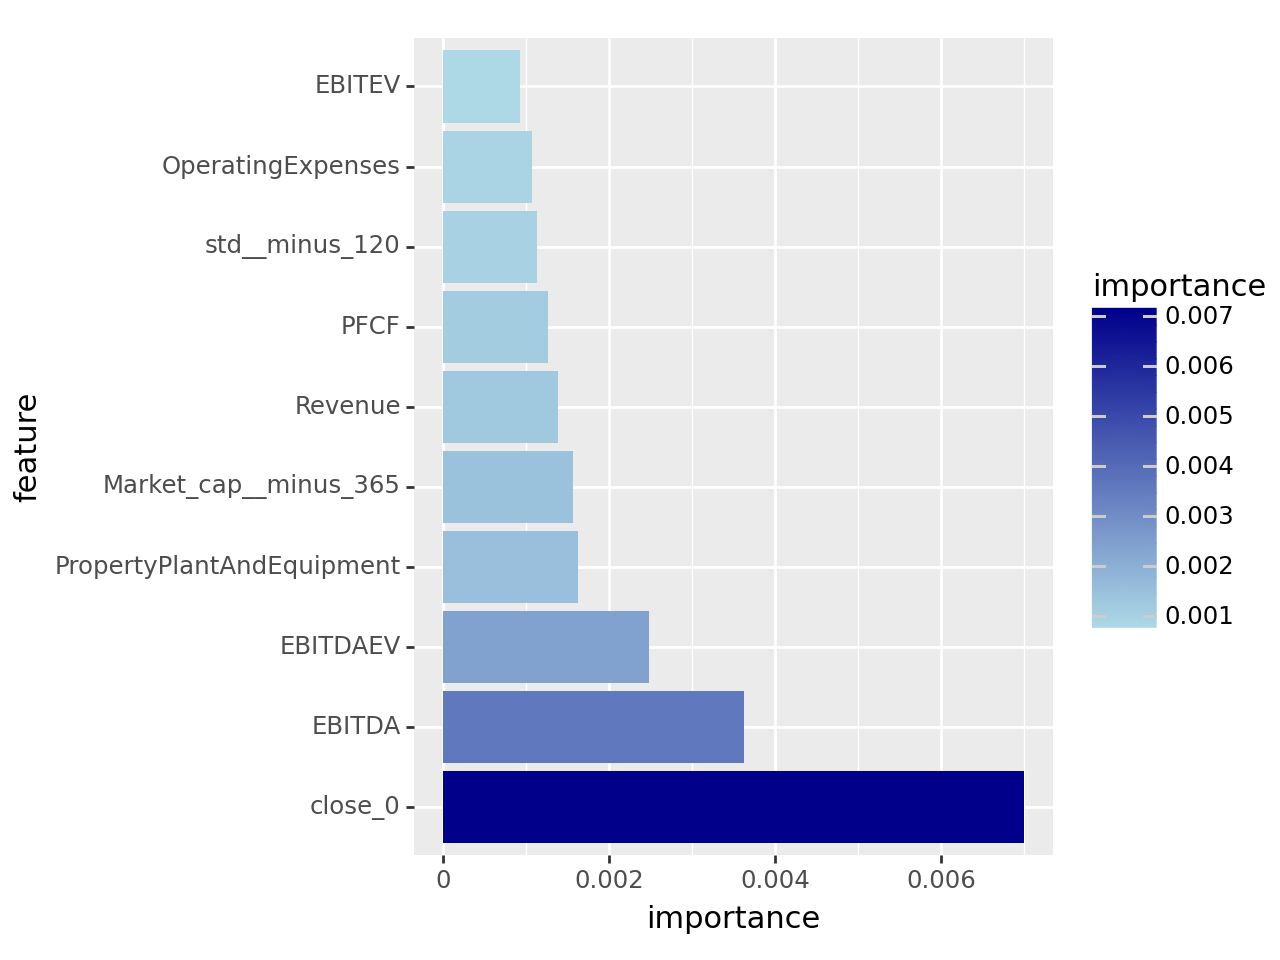

In [63]:
# Convert 'feature' to a categorical type with ordered levels
all_feature_importance_mean_importants["feature"] = pd.Categorical(
    all_feature_importance_mean_importants["feature"],
    categories=all_feature_importance_mean_importants["feature"],
    ordered=True,
)

plot = (
    ggplot(
        all_feature_importance_mean_importants,
        aes(x="feature", y="importance", fill="importance"),
    )
    + geom_col()
    + scale_fill_gradient(low="lightblue", high="darkblue")
    + coord_flip()
)  # This will make the plot horizontal

print(plot)

Anormal importance given to close_0 (actual price). This means that my actual price will determine very strongly if I'll beat the index. We could argue that this might be somehow explained by momentum, but we saw in previous lessons that reverse stock splitting are causing an important data leakages for these cases.

Let's examine the weights for each period taken, to see how predominant are these features over time:

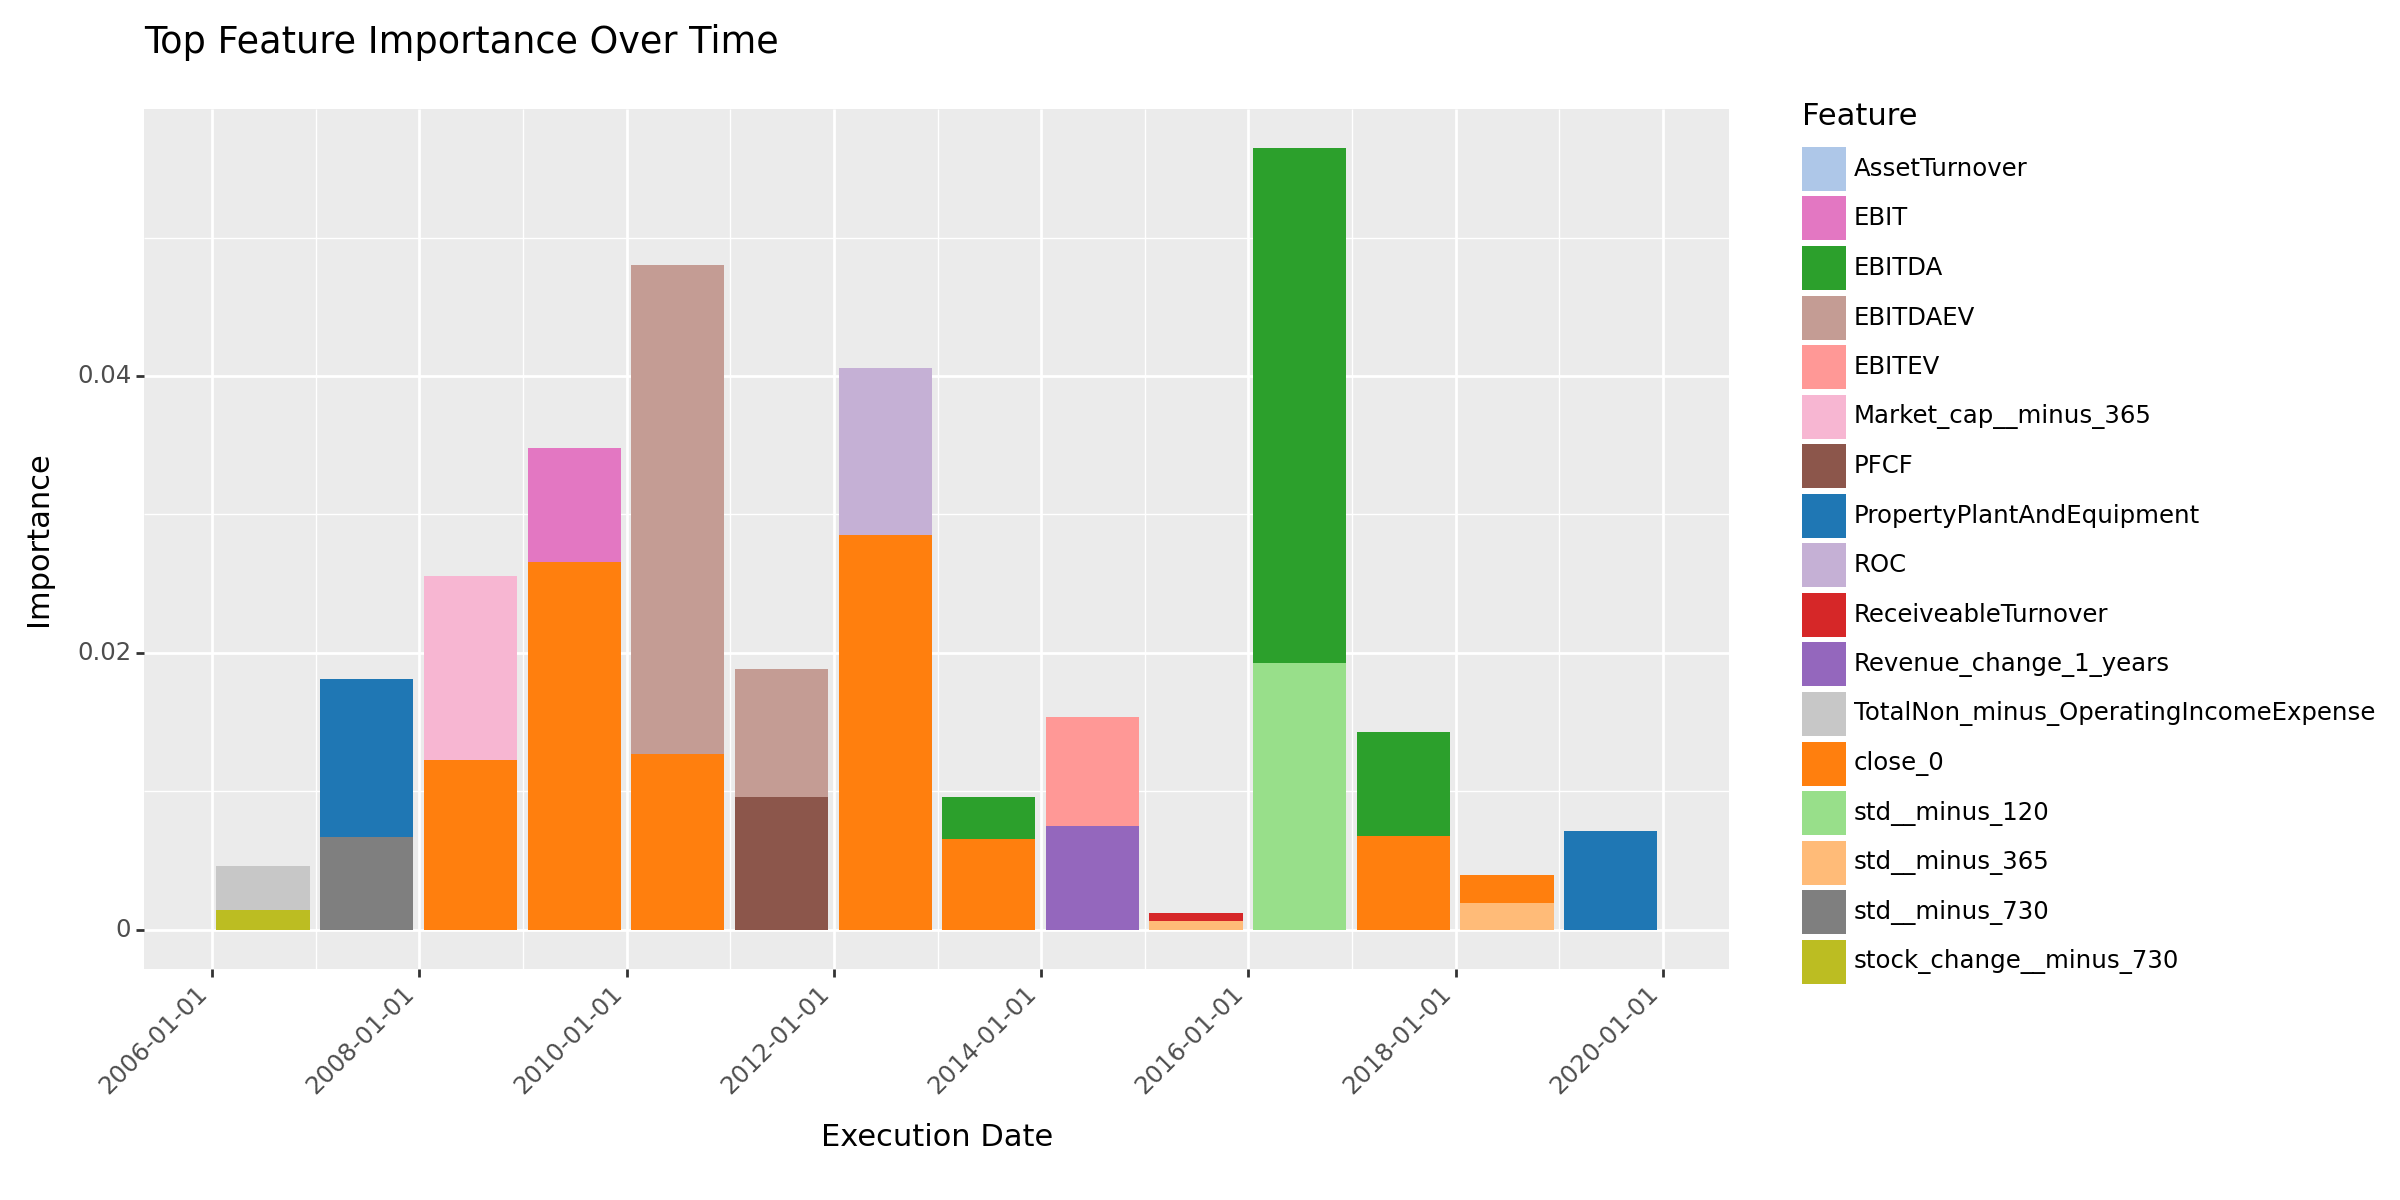

In [64]:
# Get unique features
all_feature_importance["rank"] = all_feature_importance.groupby("execution_date")[
    "importance"
].rank(ascending=False, method="first")
all_feature_importance_year = all_feature_importance[
    all_feature_importance["rank"] <= 2
]
unique_features = all_feature_importance_year["feature"].unique()

# Create palette
color_palette = plt.cm.tab20(range(len(unique_features)))
hex_color_palette = [matplotlib.colors.to_hex(c) for c in color_palette]

# Map features to cols
color_map = dict(zip(unique_features, hex_color_palette))

# Create the plot
plot = (
    ggplot(
        all_feature_importance_year,
        aes(x="execution_date", y="importance", fill="feature"),
    )
    + geom_col()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1),
        legend_position="right",
        figure_size=(12, 6),
    )
    + scale_fill_manual(values=color_map)
    + labs(
        title="Top Feature Importance Over Time",
        x="Execution Date",
        y="Importance",
        fill="Feature",
    )
)
print(plot)

`close_o` presumably very present in half of periods taken, specially in 2009 and 2012. Let's take 2009 as and example

In [113]:
all_feature_importance_year[
    all_feature_importance_year["execution_date"] == "2009-06-30"
]

,importance,feature,execution_date,rank
87,0.026532,close_0,2009-06-30,1.0
17,0.008233,EBIT,2009-06-30,2.0


In [110]:
stocks = all_predicted_tickers[all_predicted_tickers["execution_date"] == "2009-06-30"]
stocks.sort_values("prob", ascending=False).head(10)[["Ticker", "close_0", "prob"]]

,Ticker,close_0,prob
34587,EBTC,10.976029,0.547425
35124,WNEB,9.060000,0.547425
34748,PKBK,4.273207,0.547425
34793,CAC,22.686667,0.547425
34877,AROW,19.690890,0.547425
34226,FLIC,10.284444,0.547425
35626,PBHC,3.642545,0.547425
35820,NWFL,19.006060,0.547425
35789,FNLC,19.470000,0.547425
35834,SONA,8.200000,0.547425


In [111]:
stocks.sort_values("prob", ascending=False).tail(25)[["Ticker", "close_0", "prob"]]

,Ticker,close_0,prob
35476,TGH,11.490000,0.458347
35148,WINT,13356.000000,0.458231
35156,OLED,9.780000,0.458231
35069,HRTX,18.800000,0.458231
35241,IEC,3.840000,0.457656
35166,UHT,31.520000,0.457321
35804,HIG,11.870000,0.457259
35217,MS,28.510000,0.456835
34849,MFG,4.610000,0.456532
34906,AGM,4.830000,0.456270


In [112]:
# all_predicted_tickers[all_predicted_tickers['Ticker'] == 'TTNP'][['execution_date','close_0', 'prob']]

$13356 for WINT looks strange. Let's check online:

''Vestas Wind Systems stock (symbol: VWS.CO) underwent a total of 1 stock split.
The stock split occured on April 27th, 2021.
One VWS.CO share bought prior to April 27th, 2021 would equal to 5 VWS.CO shares today.''

Assessing individually with SHAP library, the idea it is that the close_0 feature is heavily lowering the probability for this case.

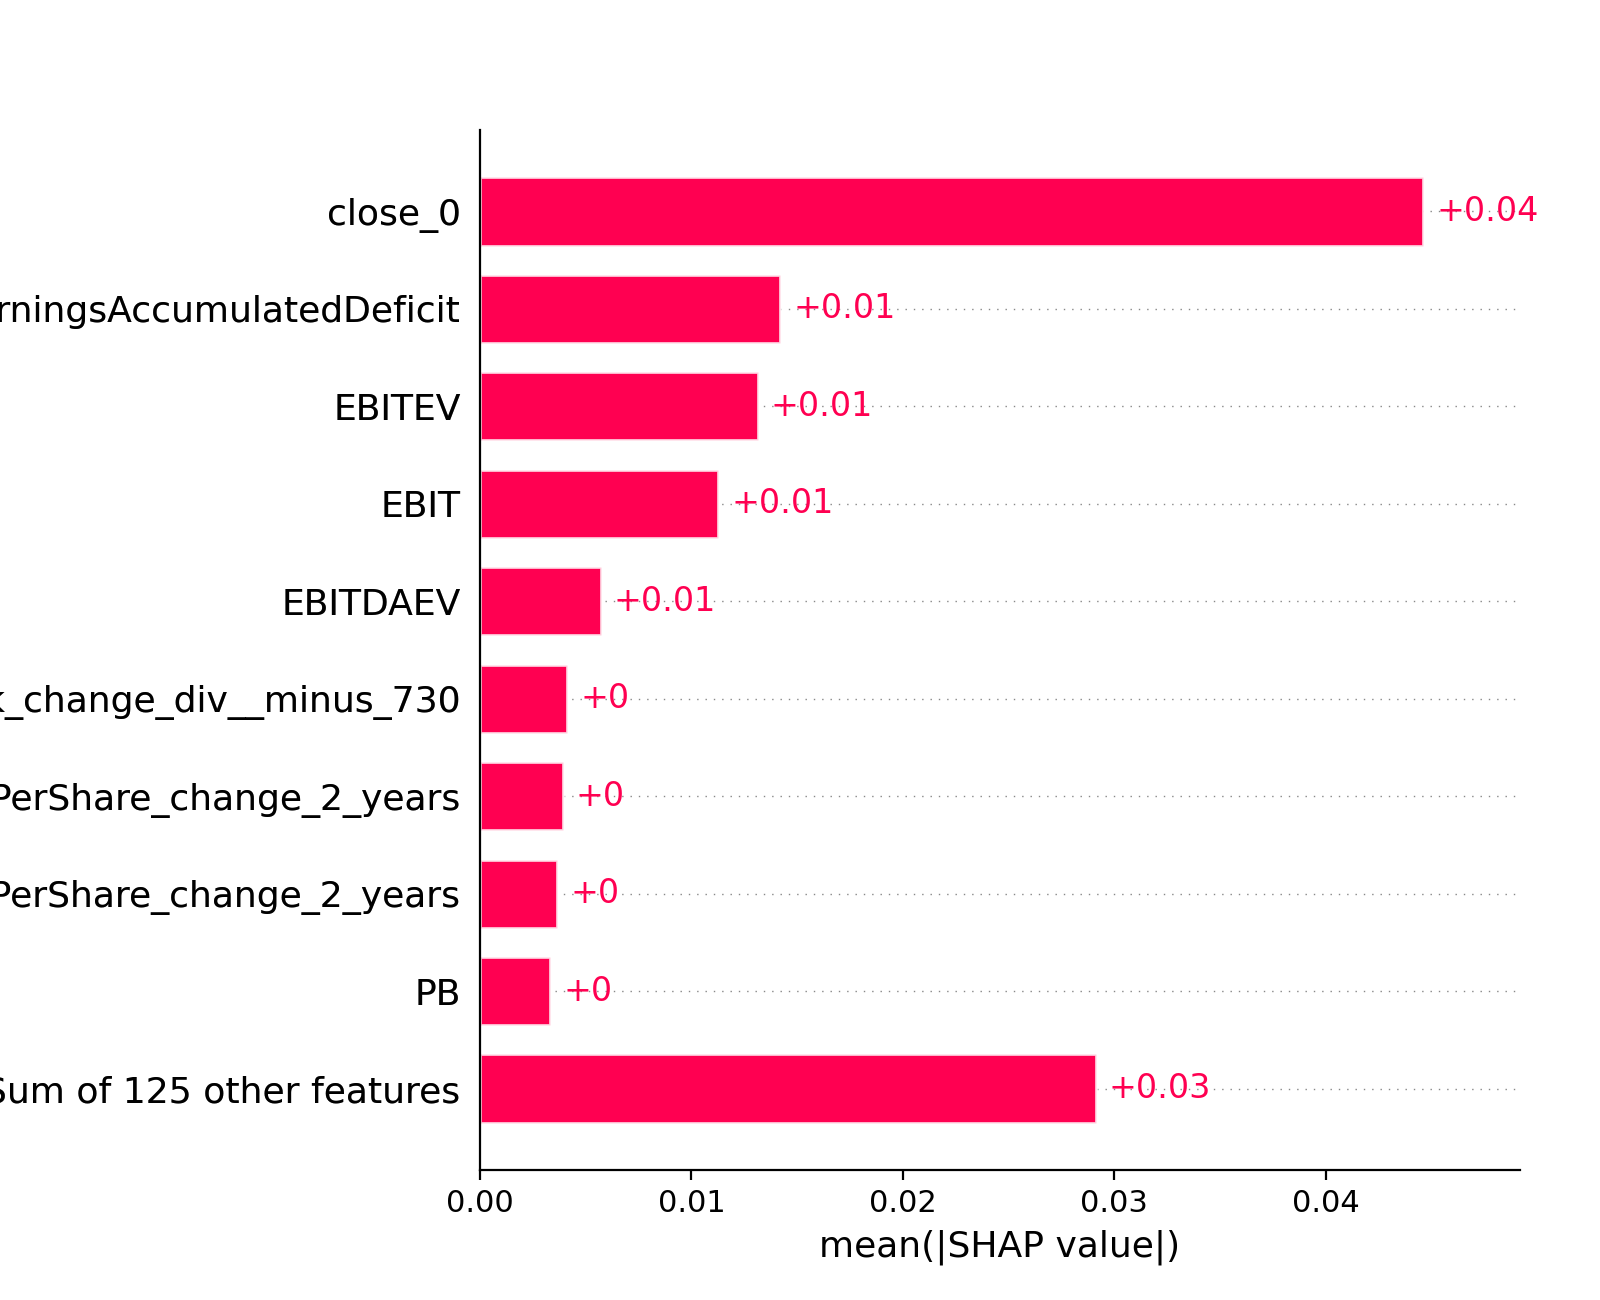

In [114]:
def get_shap_values(execution_date: str, ticker: str = None):
    """
    Generate SHAP values for a given execution date and optionally for a specific ticker.

    Parameters:
    - execution_date (str): Execution date for which to generate SHAP values.
    - all_models (dict): Dictionary containing trained models with dates as keys.
    - all_predicted_tickers (pd.DataFrame): DataFrame containing predicted tickers with their features.
    - ticker (str, optional): Specific ticker to generate SHAP values for. If None, SHAP values for all tickers are generated.

    Returns:
    - shap.Explanation: SHAP values for the specified execution date and ticker.
    """
    date = np.datetime64(execution_date)
    model = all_models.get(date)
    if model is None:
        raise ValueError(f"No model found for the date {execution_date}")

    # Filter X_test for the specified execution date
    X_test = all_predicted_tickers[all_predicted_tickers["execution_date"] == date]

    feature_names = model.booster_.feature_name()

    # Filter for a specific ticker if provided
    if ticker is not None:
        X_test = X_test[X_test["Ticker"] == ticker]
        X_test = X_test.sort_values("Ticker")
        X_test["Ticker"] = X_test["Ticker"].astype("category")

        explainer = shap.Explainer(model)
        shap_values = explainer(X_test[feature_names])
        shap_values = shap_values[..., 1]

    else:
        explainer = shap.Explainer(model, X_test[feature_names])
        shap_values = explainer(X_test[feature_names])

    return shap_values


# Example usage:
sv = get_shap_values("2009-06-30T00:00:00.000000000")
fig = plt.gcf()
ax = plt.gca()
ax.set_position([0.3, 0.1, 0.65, 0.8])
shap.plots.bar(sv, max_display=10)
plt.show()

In [116]:
ticker_top = all_predicted_tickers[
    all_predicted_tickers["execution_date"] == "2009-06-30"
].sort_values("prob", ascending=True)
ticker_top[["Ticker", "prob", "close_0"]].head(25)

,Ticker,prob,close_0
35739,FMBI,0.443811,7.310000
33982,TD,0.445386,25.870754
35811,DXCM,0.448631,6.190000
34879,CGEN,0.448631,2.010000
33969,CDMO,0.448631,29.400000
35339,HALO,0.448631,6.980000
36119,EIG,0.450245,13.550000
35123,NYMX,0.451938,5.000000
35793,NLY,0.452546,15.140000
36032,MVIS,0.452988,24.560000


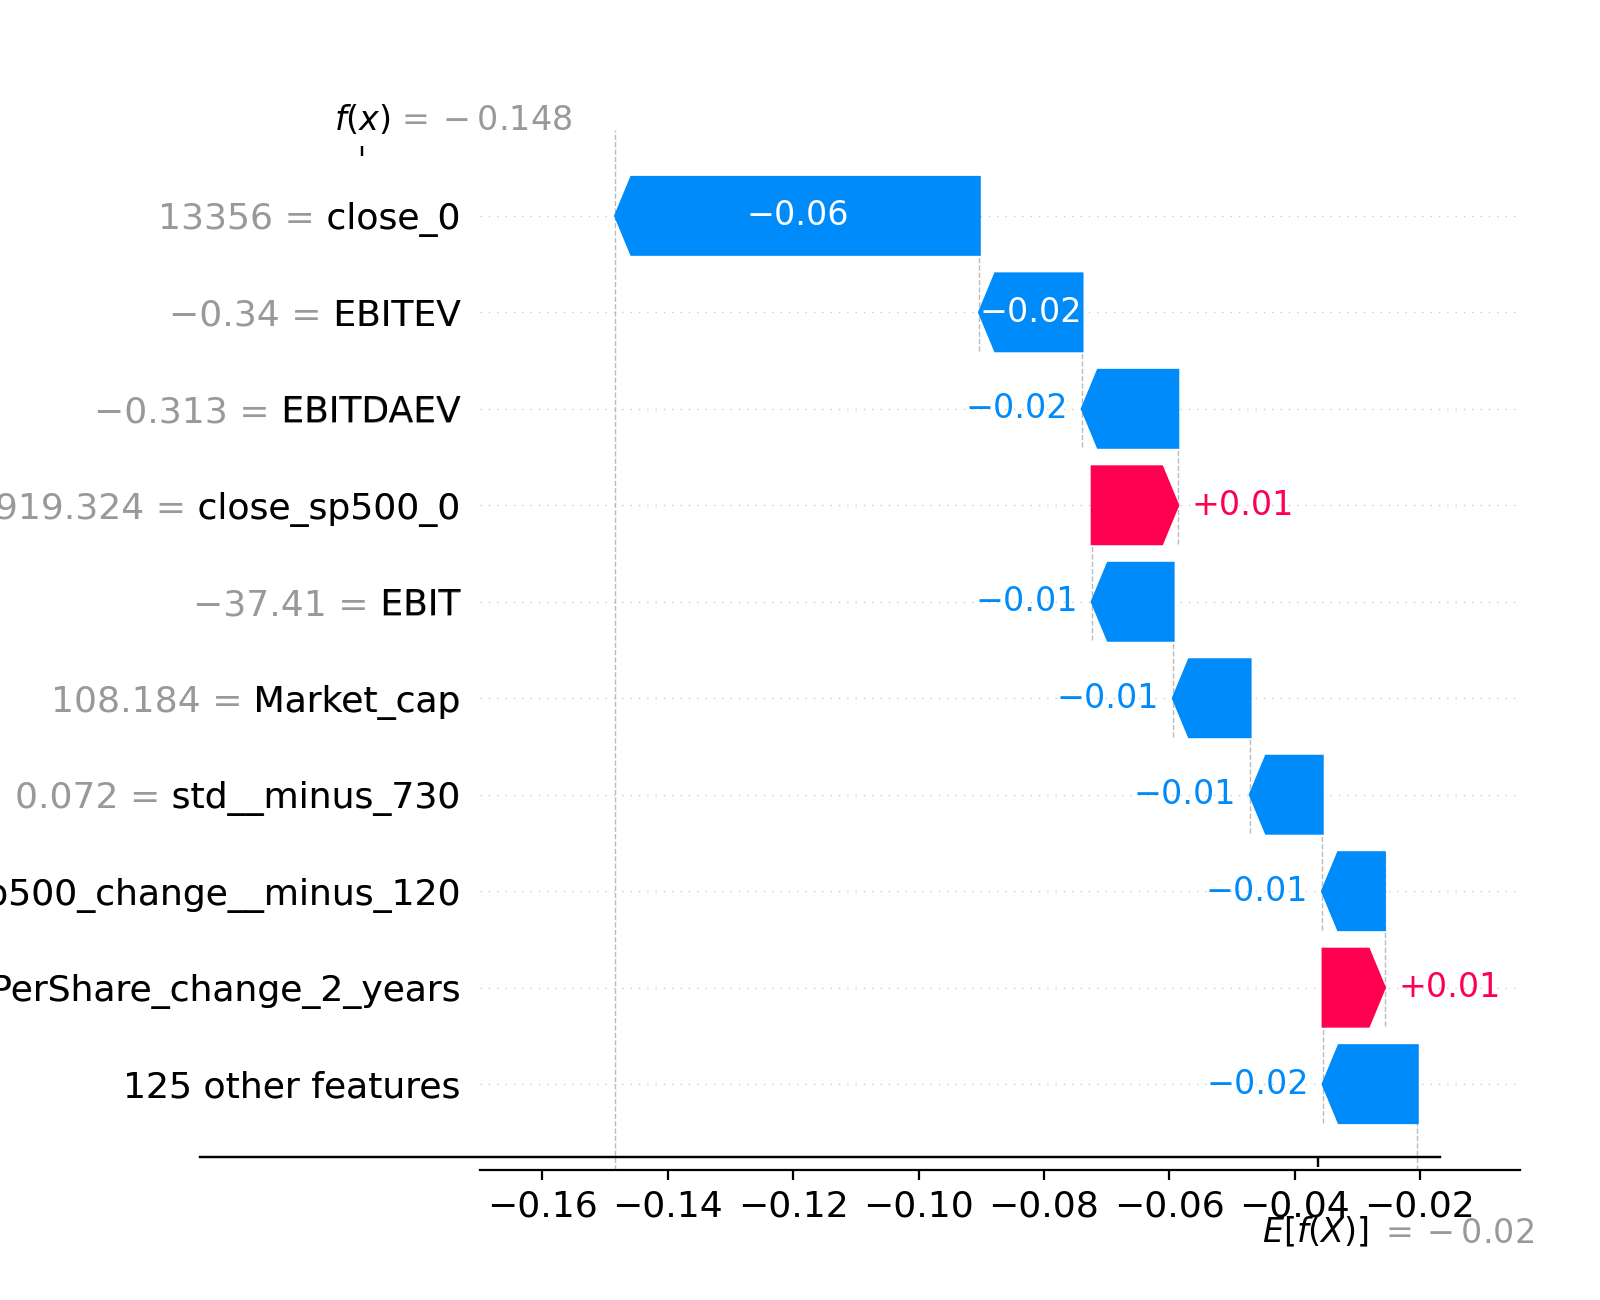

In [117]:
sv_top_ticker = get_shap_values("2009-06-30T00:00:00.000000000", "WINT")
fig = plt.gcf()
ax = plt.gca()
ax.set_position([0.3, 0.1, 0.65, 0.8])
shap.plots.waterfall(sv_top_ticker[0])

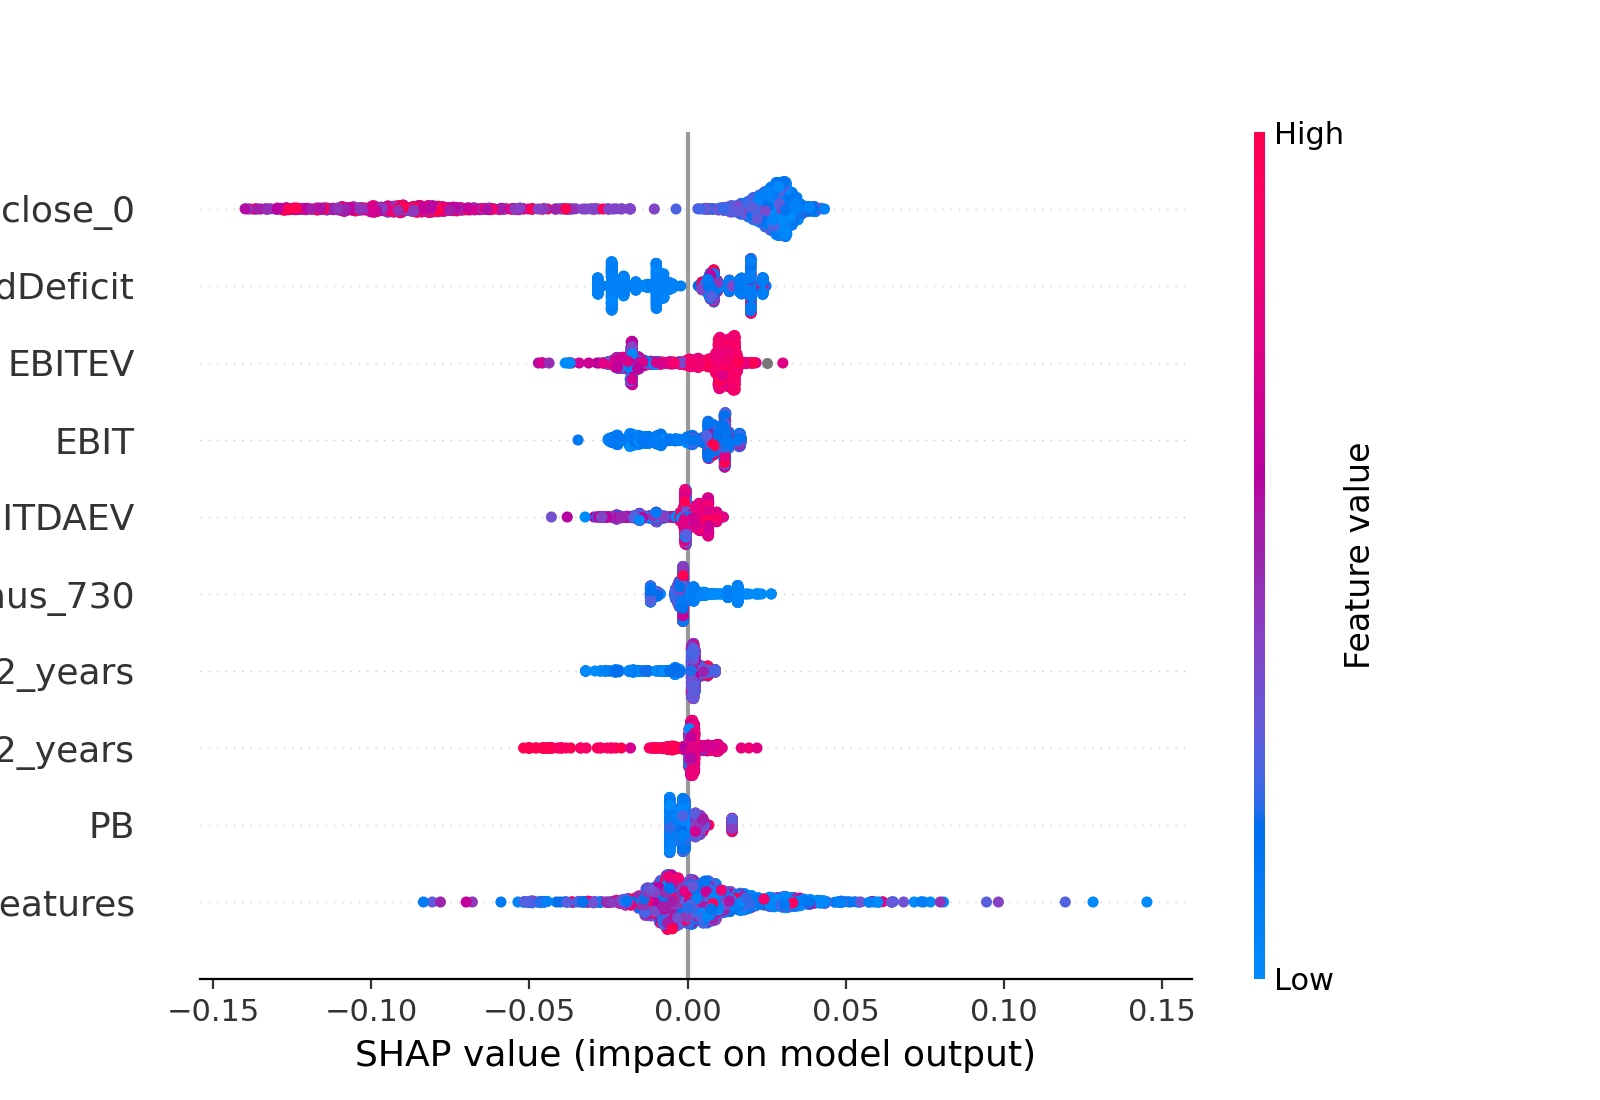

In [118]:
shap.plots.beeswarm(sv)

Indeed we see that the most penalizing feature was close_0. In the plot, the feature close_0 has a SHAP value of approximately -0.06. This value indicates that for the specific instance being analyzed, the close_0 feature contributes to decreasing the model's output by 0.06 units from the base value (average model output over the dataset). If the model's output is a probability, this would mean the presence or value of close_0 for this instance decreases the predicted probability of the positive class by 0.06.

The reverse stock splitting in this case is leaking info to the past; i.e. if the company approved a stock split (bad signal) it means it didn't go under good circumstances and the price is being calculated backwards, so higher prices will be associated with potential future stock splits, hence company in not good economic position and performing bad against sp500.

In this case, we were carrying an investigation to verify a different stock splitting event presented in class, but I wouldn't conclude that fast that there should be something wrong with the model and the importance given to close_0 value. If I had more time, I would like to research a bit and confirm if this might be also something related to the "regression to the mean" phenomenon, which could give us an idea on why lower stocks might have higher probabilities for surpassing sp500!

One possible solution would be to have the adjusted-prices for stocks, so stock splitting would not affect actual prices, but we do not have that feature in the current dataset (maybe online), so we will just drop the suspicious columns.

## 4. Potential improvements

Having said that, let's do some quick adjustments and will re-compute all the metrics to see if the model has improved:
* We will experiment with XGBoost model as it normally has a better performance for tabular data over the rest classification models, although it may be more time-consuming.
* Assuming that stock markets are influenced by economic cycles, we propose that the average economic cycle lasts approximately 6 to 8 years. To incorporate this hypothesis, we aim to introduce a feature that identifies the current economic phase (e.g., inflationary/deflationary, expansion/contraction, interest rates, etc). To simplify this analysis, we'll use the past 4 years as a proxy to define the upcoming quarters' economic conditions. Therefore, we'll train the model on the most recent 16 n_train_quarters instead of the previous 36 quarters.
* With that, now we will train for every quarter (`period_frequency` = 1) in contrast with just using 1 per each 4 periods.

In [13]:
def get_columns_to_remove():
    columns_to_remove = [
        "date",
        "improve_sp500",
        "Ticker",
        "freq",
        "set",
        "close_sp500_365",
        "close_365",
        "stock_change_365",
        "sp500_change_365",
        "stock_change_div_365",
        "stock_change_730",
        "sp500_change_365",
        "stock_change_div_730",
        "diff_ch_sp500",
        "diff_ch_avg_500",
        "execution_date",
        "target",
        "index",
        "quarter",
        "std_730",
        "count",
    ]

    columns_to_remove = columns_to_remove + technical_features

    return columns_to_remove


def clean_data(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.ffill(inplace=True)


def train_model(train_set, test_set, params, n_estimators=300, path_smooth=None):
    columns_to_remove = get_columns_to_remove()

    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    def custom_eval_metric(preds, train_data):
        top_dataset = get_top_tickers_per_prob(preds)
        weighted_return = get_weighted_performance_of_stocks(
            top_dataset, "diff_ch_sp500"
        )
        return "custom_eval_metric", weighted_return

    # Initialize the model with custom eval_metric and other parameters
    clf = xgb.XGBClassifier(**params)

    model = clf.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric=custom_eval_metric,  # Use the custom evaluation function
        verbose=False,
    )

    # Compute feature importance
    pi = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=0)
    feature_names = X_test.columns
    df_feature_importance = pd.DataFrame(
        {"importance": pi.importances_mean, "feature": feature_names}
    )

    return model, X_train, X_test, df_feature_importance


def run_model_for_execution_date(
    execution_date: str,
    all_results: Dict,
    all_predicted_tickers_list: List[pd.DataFrame],
    all_models: Dict,
    all_feature_importance: pd.DataFrame,
    params: Dict,
    include_nulls_in_test: bool = False,
) -> Tuple[
    Dict,
    List[pd.DataFrame],
    Dict,
    xgb.XGBClassifier,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
]:
    """
    Runs the model for a specific execution date and computes feature importance.

    Parameters:
    - execution_date (str): The execution date for the model.
    - all_results (Dict): Dictionary to store all results.
    - all_predicted_tickers_list (List[pd.DataFrame]): List to store all predicted tickers.
    - all_models (Dict): Dictionary to store all models.
    - all_feature_importance (pd.DataFrame): DataFrame to store all feature importances.
    - params (Dict): Parameters for the XGBoost model.
    - include_nulls_in_test (bool): Flag to include nulls in the test set.

    Returns:
    - Tuple[Dict, List[pd.DataFrame], Dict, xgb.XGBClassifier, pd.DataFrame, pd.DataFrame, pd.DataFrame]: Updated results, predicted tickers list, models, trained model, training features, testing features, feature importance dataframe.
    """
    global train_set
    global test_set

    train_set, test_set = split_train_test_by_period(
        data_set, execution_date, include_nulls_in_test=include_nulls_in_test
    )
    clean_data(train_set)
    clean_data(test_set)
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape

    model = None
    X_train = None
    X_test = None

    if train_size > 0 and test_size > 0:
        model, X_train, X_test, df_feature_importance = train_model(
            train_set, test_set, params
        )
        test_set["prob"] = model.predict_proba(X_test)[:, 1]
        predicted_tickers = test_set.sort_values("prob", ascending=False)
        predicted_tickers["execution_date"] = execution_date
        all_results[execution_date] = model.evals_result_
        all_models[execution_date] = model
        all_predicted_tickers_list.append(predicted_tickers)

        # Append feature importance for this execution date
        df_feature_importance["execution_date"] = execution_date
        all_feature_importance = pd.concat(
            [all_feature_importance, df_feature_importance]
        )

    return (
        all_results,
        all_predicted_tickers_list,
        all_models,
        X_train,
        X_test,
        all_feature_importance,
    )

In [14]:
params = {
    "random_state": 1,
    "n_jobs": 10,
    "n_estimators": 20,
    "learning_rate": 0.01,
    "reg_lambda": 0.3,
    "objective": "binary:logistic",
    "missing": np.nan,
}

n_train_quarters = 16
period_frequency = 1

all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_feature_importance = pd.DataFrame()

execution_dates = np.sort(data_set["execution_date"].unique())
# start_date = np.datetime64('2015-06-30')
# execution_dates = [date for date in execution_dates if date >= start_date]


for i, execution_date in enumerate(execution_dates):
    if i % period_frequency == 0:
        print(f"Execution Date {i}: {execution_date}")
        (
            all_results,
            all_predicted_tickers_list,
            all_models,
            X_train,
            X_test,
            all_feature_importance,
        ) = run_model_for_execution_date(
            execution_date,
            all_results,
            all_predicted_tickers_list,
            all_models,
            all_feature_importance,
            params,
        )

Execution Date 0: 2005-06-30T00:00:00.000000000
Execution Date 1: 2005-09-30T00:00:00.000000000
Execution Date 2: 2005-12-30T00:00:00.000000000
Execution Date 3: 2006-03-31T00:00:00.000000000
Execution Date 4: 2006-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 5: 2006-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 6: 2006-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 7: 2007-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 8: 2007-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 9: 2007-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 10: 2007-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 11: 2008-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 12: 2008-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 13: 2008-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 14: 2008-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 15: 2009-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 16: 2009-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 17: 2009-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 18: 2009-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 19: 2010-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 20: 2010-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 21: 2010-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 22: 2010-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 23: 2011-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 24: 2011-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 25: 2011-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 26: 2011-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 27: 2012-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 28: 2012-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 29: 2012-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 30: 2012-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 31: 2013-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 32: 2013-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 33: 2013-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 34: 2013-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 35: 2014-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 36: 2014-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 37: 2014-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 38: 2014-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 39: 2015-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 40: 2015-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 41: 2015-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 42: 2015-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 43: 2016-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 44: 2016-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 45: 2016-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 46: 2016-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 47: 2017-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 48: 2017-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 49: 2017-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 50: 2017-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 51: 2018-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 52: 2018-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 53: 2018-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 54: 2018-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 55: 2019-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 56: 2019-06-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 57: 2019-09-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 58: 2019-12-30T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 59: 2020-03-31T00:00:00.000000000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Execution Date 60: 2020-06-30T00:00:00.000000000
Execution Date 61: 2020-09-30T00:00:00.000000000
Execution Date 62: 2020-12-30T00:00:00.000000000
Execution Date 63: 2021-03-27T00:00:00.000000000


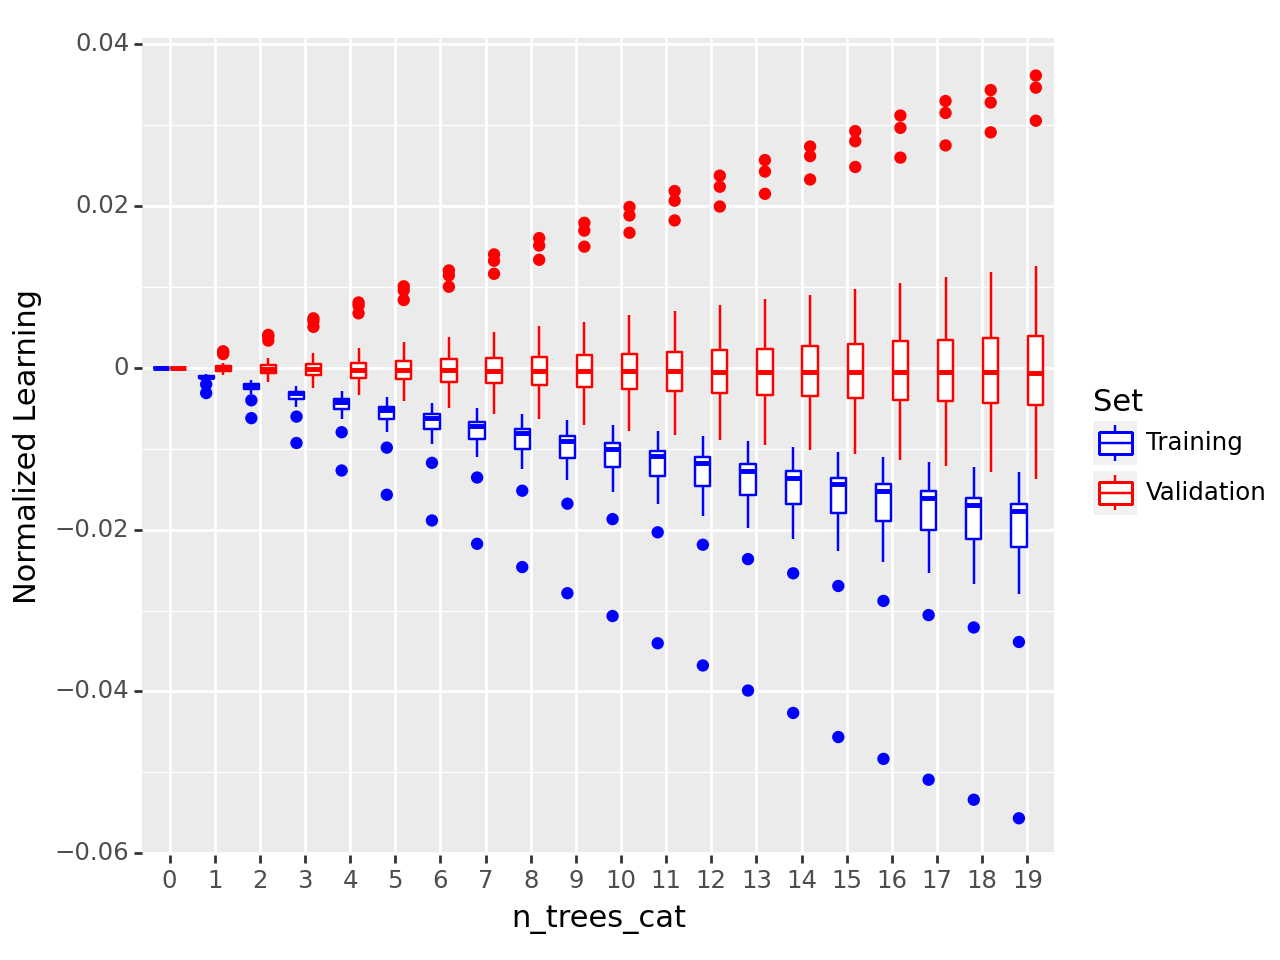

In [15]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df = pd.concat([df, df_tmp])

    df["execution_date"] = df["execution_date"].astype(str)

    return df


test_results = parse_results_into_df("validation_1")
train_results = parse_results_into_df("validation_0")


def compute_learning_rate(set_: str, all_results: dict) -> pd.DataFrame:
    """
    Calculate the normalized learning rates for the model

    Parameters:
    - set_ (str): The dataset type ('training' or 'valid_0').
    - all_results (dict): Dictionary containing training results for each execution date.

    Returns:
    - pd.DataFrame: DataFrame with normalized learning rates, including execution dates and tree categories.
    """

    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[date][set_])
        df_tmp["n_trees"] = range(len(df_tmp))
        df_tmp["execution_date"] = date
        df = pd.concat([df, df_tmp])

    # Calculate the % diff respect to first tree
    df["first_tree_logloss"] = df.groupby(["execution_date"])["logloss"].transform(
        "first"
    )
    df[f"normalized_learning_{set_}"] = (df["logloss"] - df["first_tree_logloss"]) / df[
        "first_tree_logloss"
    ]
    df = df.drop(columns="first_tree_logloss")

    return df


learning_rates_train = compute_learning_rate("validation_0", all_results)
learning_rates_test = compute_learning_rate("validation_1", all_results)

# Filter for n_trees <= 20
learning_rates_train = learning_rates_train[learning_rates_train["n_trees"] <= 20]
learning_rates_test = learning_rates_test[learning_rates_test["n_trees"] <= 20]

# Convert 'n_trees' to a categorical variable for better plotting
learning_rates_train = learning_rates_train[
    ["n_trees", "normalized_learning_validation_0", "execution_date"]
]
learning_rates_test = learning_rates_test[
    ["n_trees", "normalized_learning_validation_1", "execution_date"]
]

# Rename columns for merging
learning_rates_train.rename(
    columns={"normalized_learning_validation_0": "Normalized Learning"}, inplace=True
)
learning_rates_test.rename(
    columns={"normalized_learning_validation_1": "Normalized Learning"}, inplace=True
)

learning_rates_train["Set"] = "Training"
learning_rates_test["Set"] = "Validation"

learning_rates_combined = pd.concat([learning_rates_train, learning_rates_test])


learning_rates_combined["n_trees_cat"] = pd.Categorical(
    learning_rates_combined["n_trees"],
    categories=sorted(learning_rates_combined["n_trees"].unique()),
)

# Plotting
plot = (
    ggplot(
        learning_rates_combined,
        aes(x="n_trees_cat", y="Normalized Learning", color="Set"),
    )
    + geom_boxplot()
    + scale_color_manual(values=["blue", "red"])
)

print(plot)

Let's check the feature imporance again:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


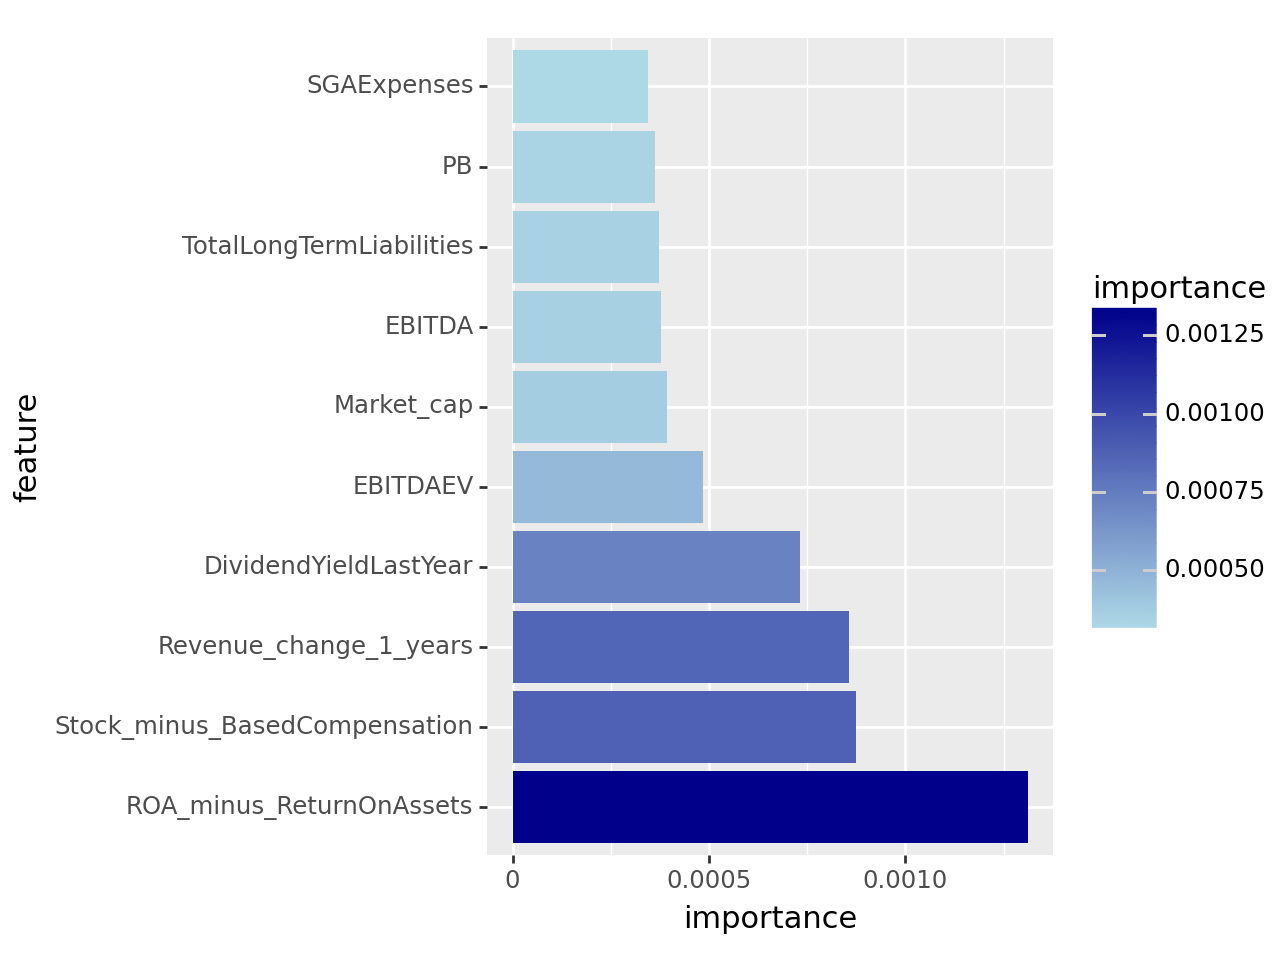

In [16]:
all_feature_importance = all_feature_importance.sort_values(
    ["execution_date", "importance"], ascending=False
)
all_feature_importance_mean = (
    all_feature_importance.groupby("feature")["importance"].mean().reset_index()
)
all_feature_importance_mean = all_feature_importance_mean.sort_values(
    "importance", ascending=False
)
all_feature_importance_mean_importants = all_feature_importance_mean.head(10)

all_feature_importance_mean_importants["feature"] = pd.Categorical(
    all_feature_importance_mean_importants["feature"],
    categories=all_feature_importance_mean_importants["feature"],
    ordered=True,
)

plot = (
    ggplot(
        all_feature_importance_mean_importants,
        aes(x="feature", y="importance", fill="importance"),
    )
    + geom_col()
    + scale_fill_gradient(low="lightblue", high="darkblue")
    + coord_flip()
)  # This will make the plot horizontal

print(plot)

And if we inspect one particular value for 2016-06-30 (first we need to edit the get_shap_values func, replacing the booster__ attribute with the get_booster() method)

In [17]:
import numpy as np
import shap
import pandas as pd


def get_shap_values(execution_date: str, ticker: str = None):
    """
    Generate SHAP values for a given execution date and optionally for a specific ticker.

    Parameters:
    - execution_date (str): Execution date for which to generate SHAP values.
    - all_models (dict): Dictionary containing trained models with dates as keys.
    - all_predicted_tickers (pd.DataFrame): DataFrame containing predicted tickers with their features.
    - ticker (str, optional): Specific ticker to generate SHAP values for. If None, SHAP values for all tickers are generated.

    Returns:
    - shap.Explanation: SHAP values for the specified execution date and ticker.
    """
    date = np.datetime64(execution_date)
    model = all_models.get(date)
    if model is None:
        raise ValueError(f"No model found for the date {execution_date}")

    # Filter X_test for the specified execution date
    X_test = all_predicted_tickers[all_predicted_tickers["execution_date"] == date]

    feature_names = model.get_booster().feature_names

    # Filter for a specific ticker if provided
    if ticker is not None:
        X_test = X_test[X_test["Ticker"] == ticker]
        X_test = X_test.sort_values("Ticker")
        X_test["Ticker"] = X_test["Ticker"].astype("category")

        explainer = shap.Explainer(model)
        shap_values = explainer(X_test[feature_names])
        shap_values = shap_values[..., 1]

    else:
        explainer = shap.Explainer(model, X_test[feature_names])
        shap_values = explainer(X_test[feature_names])

    return shap_values

In [18]:
all_predicted_tickers = []
all_predicted_tickers = pd.concat(all_predicted_tickers_list)
all_predicted_tickers.head()

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,...,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500,count,target,prob
9837,BRFS,2006-03-31,0.0770,-18.938,-0.533,18.025,8.200,-2.4880,-4.031,2.352,...,2.096248e+15,NaN,0.189180,NaN,742.443,NaN,0.808165,2052,1.0,0.653183
9460,JPM,2006-03-31,0.0113,53821.000,-34501.000,-19141.000,513228.000,-0.5480,-125.000,-9752.000,...,-1.071134e+00,NaN,0.019588,NaN,126085.336,NaN,0.002404,2052,1.0,0.651234
9748,T,2006-03-31,0.1091,-70.000,-2555.000,2458.000,1057.000,-1.8060,509.000,-189.000,...,1.472973e+00,NaN,0.228051,NaN,78731.250,NaN,0.353741,2052,1.0,0.649785
8577,BTI,2006-03-31,0.1207,-354.679,18.269,333.527,65.989,-2.5758,2.037,-8.631,...,-4.341307e+00,NaN,0.010495,NaN,88897.800,NaN,0.222591,2052,1.0,0.647899
8619,GNW,2006-03-31,0.0233,-76.000,-649.000,771.000,1909.000,15.0000,-51.536,330.000,...,1.223108e+00,NaN,0.278079,NaN,14942.689,NaN,-0.186275,2052,0.0,0.647543


[16:49:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


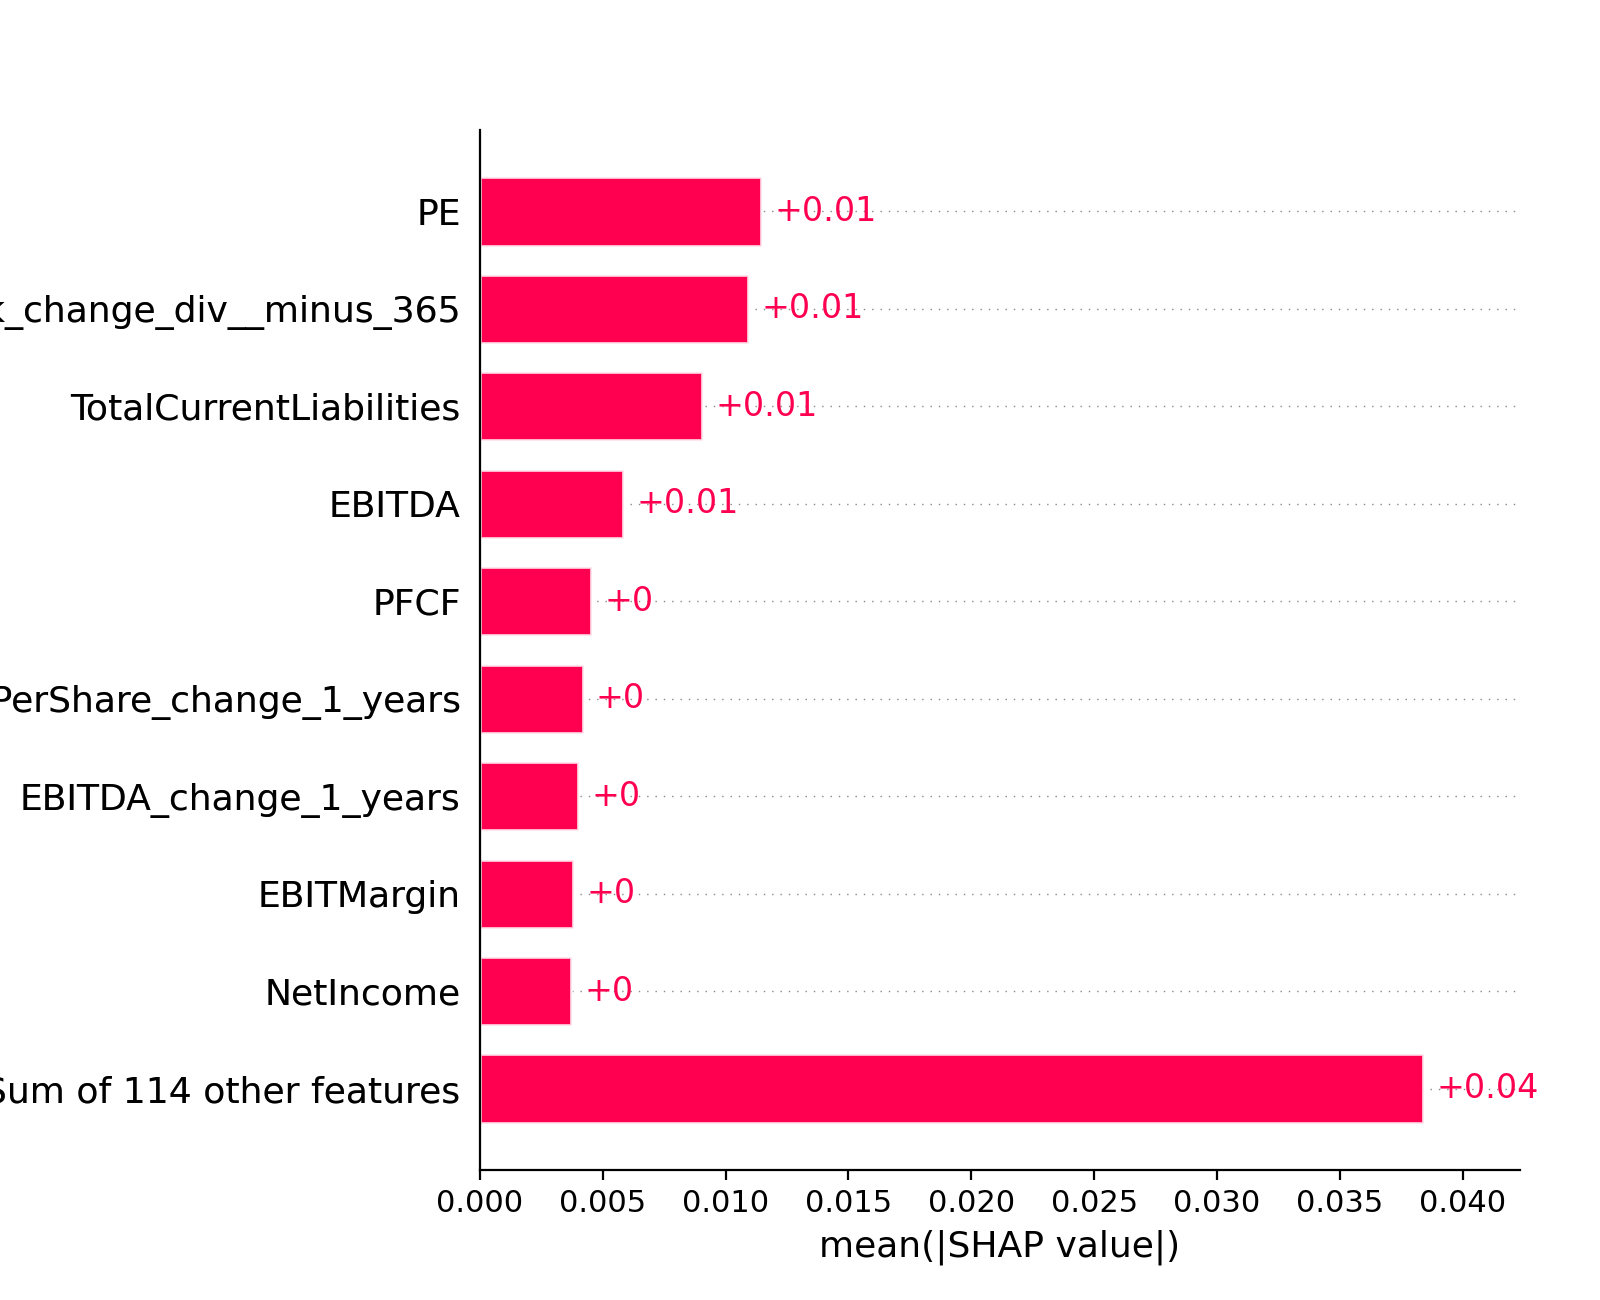

In [19]:
sv = get_shap_values("2016-06-30T00:00:00.000000000")
fig = plt.gcf()
ax = plt.gca()
ax.set_position([0.3, 0.1, 0.65, 0.8])
shap.plots.bar(sv, max_display=10)
plt.show()

In [20]:
stocks = all_predicted_tickers[all_predicted_tickers["execution_date"] == "2016-06-30"]
stocks.sort_values("prob", ascending=False).head(10)[["Ticker", "prob"]]

,Ticker,prob
107215,SNOA,0.520623
106133,FPI,0.519074
106966,EVOK,0.519074
107090,MACK,0.516523
107407,WVE,0.515716
106530,HCA,0.514517
107053,TGH,0.514380
107335,WMC,0.513756
106284,TVTY,0.513748
106799,PTMN,0.512834


In [21]:
stocks.sort_values("prob", ascending=False).tail(10)[["Ticker", "prob"]]

,Ticker,prob
105677,TWO,0.441638
107318,AJX,0.441477
105898,ARCC,0.441477
106206,VOC,0.441455
106889,ET,0.437134
104953,MU,0.436772
107016,BPT,0.423908
104957,SAR,0.423908
104749,NRT,0.423908
106185,CPSS,0.423908


[16:49:55] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


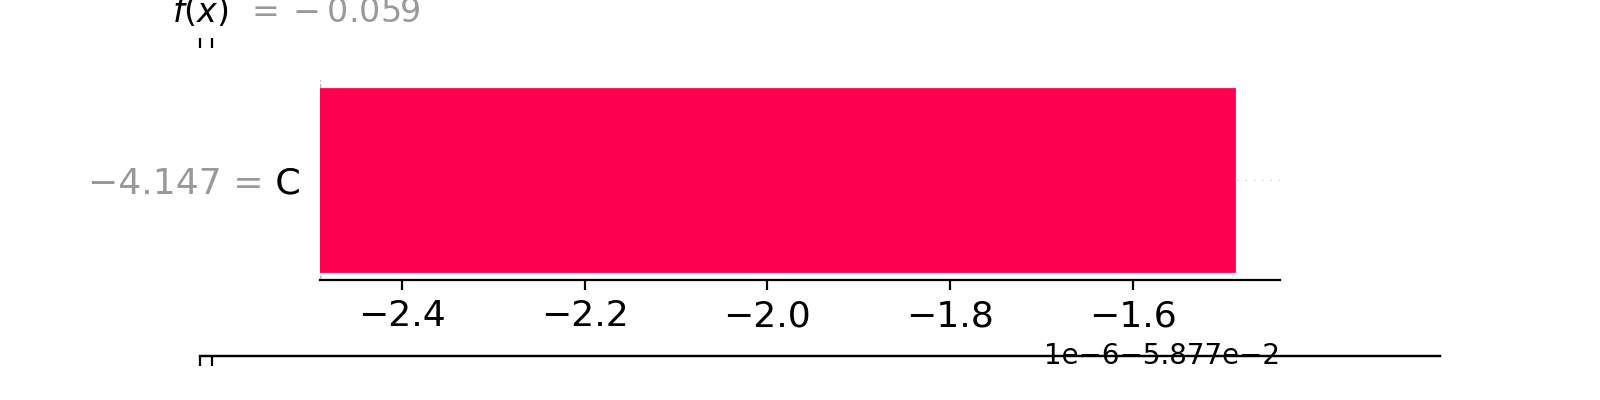

In [22]:
sv_top_ticker = get_shap_values("2016-06-30T00:00:00.000000000", "NRT")
fig = plt.gcf()
ax = plt.gca()
ax.set_position([0.2, 0.3, 0.6, 0.5])
# Check if sv_top_ticker is empty
if sv_top_ticker.shape[0] > 0:
    shap.plots.waterfall(sv_top_ticker)
else:
    print("No SHAP values available for the specified ticker and date.")

plt.show()

I understand that this horrible plot shows that no feature plays an important role here (x scale is ~0), as described previously.

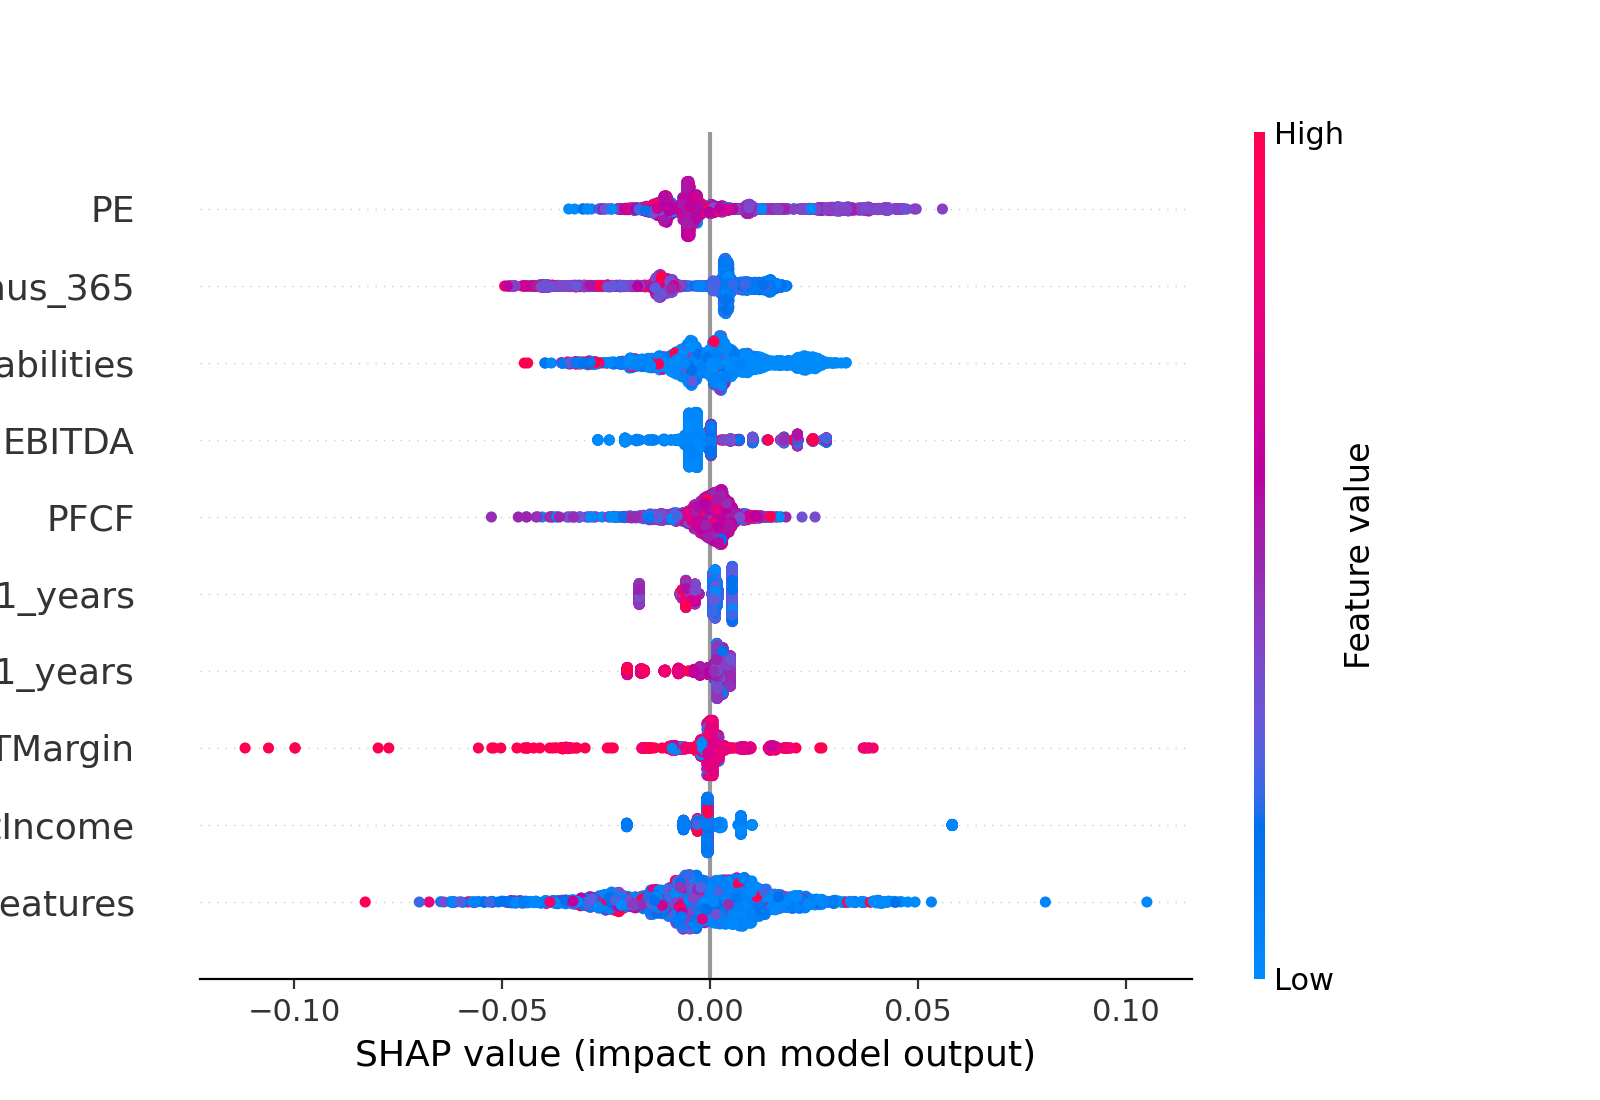

In [23]:
shap.plots.beeswarm(sv)

Pretty much balanced for all the features. Simplifying a bit, lows EBITDA penalizes the prediction (low earnings -> bad company); also high Price-to-Free Cash Flow impacts positive on the prediction (investors have high expectations for the company -> good company), so at a first glance makes sense to me.

In [24]:
test_results = parse_results_into_df("validation_1")
train_results = parse_results_into_df("validation_0")

In [25]:
test_results.head()

,logloss,custom_eval_metric,n_trees,execution_date
0,0.720886,0.063183,0,2006-06-30
1,0.720558,0.080899,1,2006-06-30
2,0.720176,0.359252,2,2006-06-30
3,0.719796,0.356899,3,2006-06-30
4,0.719511,0.477344,4,2006-06-30


In [26]:
train_results.head()

,logloss,custom_eval_metric,n_trees,execution_date
0,0.676475,2.835162,0,2006-06-30
1,0.674363,0.440108,1,2006-06-30
2,0.672265,0.266251,2,2006-06-30
3,0.670189,0.468292,3,2006-06-30
4,0.667889,0.412792,4,2006-06-30


In [27]:
test_results_final_tree = test_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")
train_results_final_tree = train_results.sort_values(
    ["execution_date", "n_trees"]
).drop_duplicates("execution_date", keep="last")

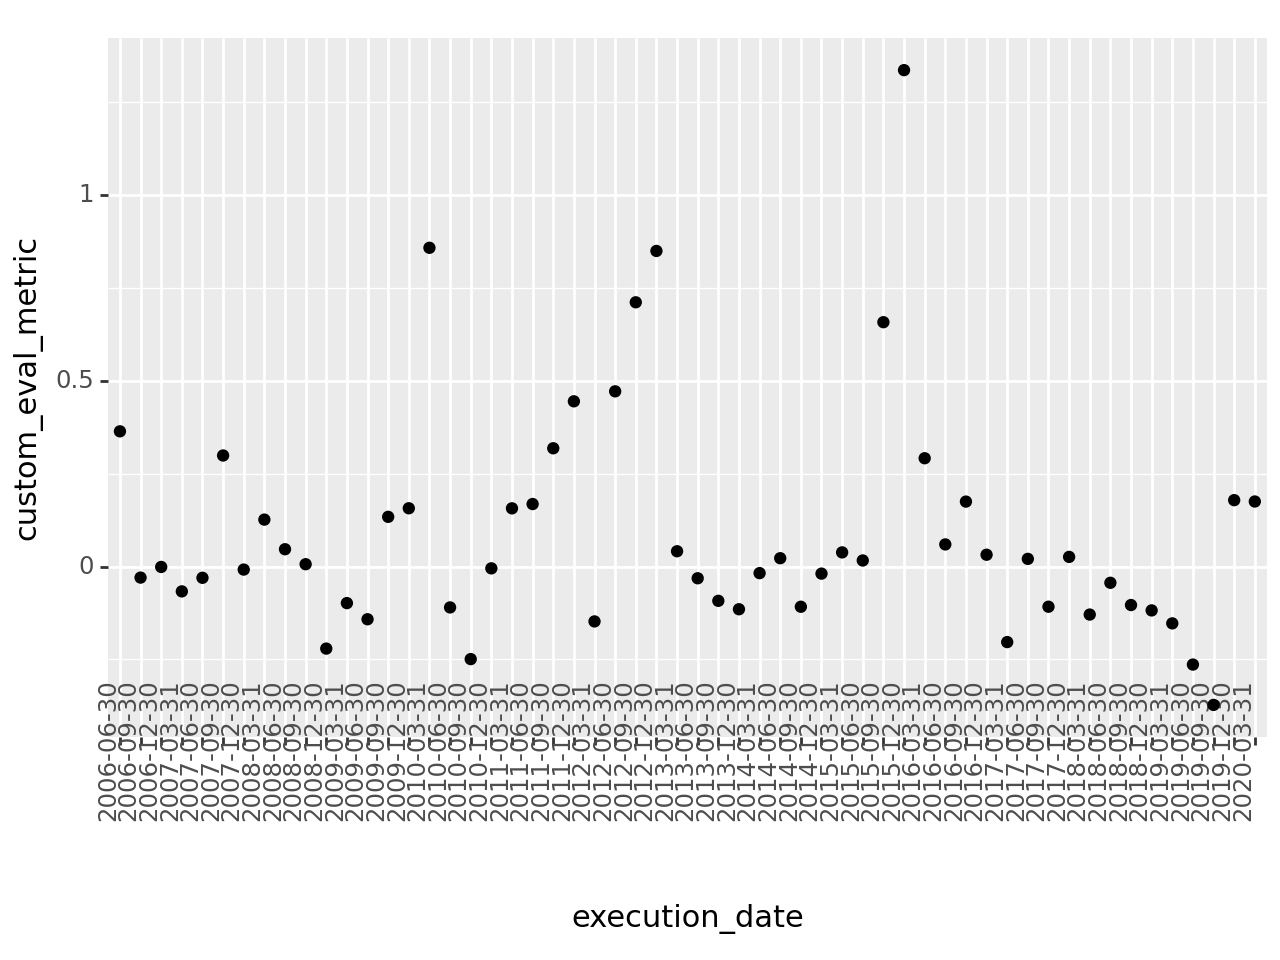

<Figure Size: (640 x 480)>

In [28]:
(
    ggplot(test_results_final_tree)
    + geom_point(aes(x="execution_date", y="custom_eval_metric"))
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

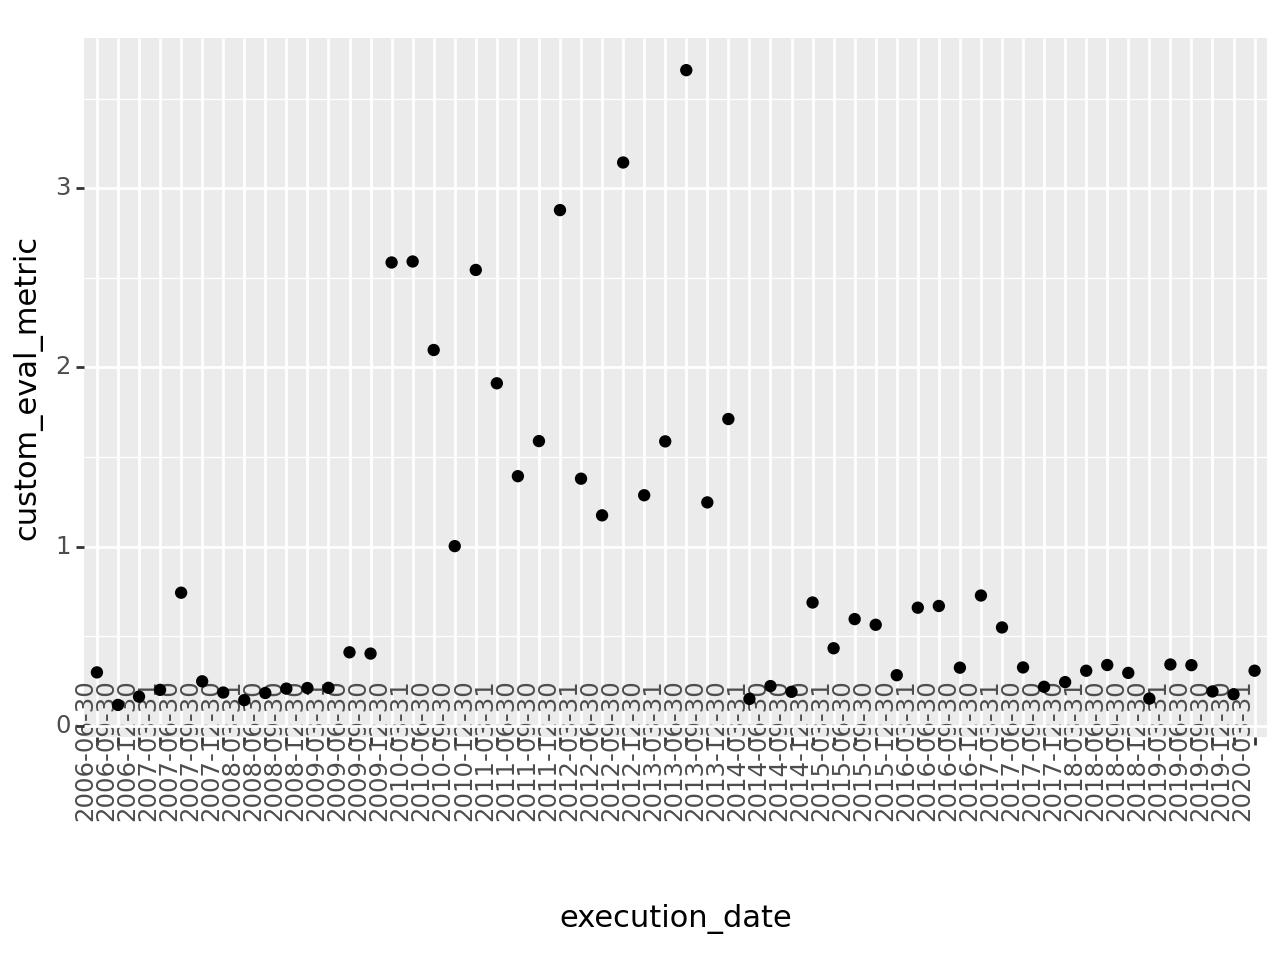

<Figure Size: (640 x 480)>

In [29]:
(
    ggplot(train_results_final_tree)
    + geom_point(aes(x="execution_date", y="custom_eval_metric"))
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

In [30]:
test_results_final_tree["execution_date"].unique()

array(['2006-06-30', '2006-09-30', '2006-12-30', '2007-03-31',
       '2007-06-30', '2007-09-30', '2007-12-30', '2008-03-31',
       '2008-06-30', '2008-09-30', '2008-12-30', '2009-03-31',
       '2009-06-30', '2009-09-30', '2009-12-30', '2010-03-31',
       '2010-06-30', '2010-09-30', '2010-12-30', '2011-03-31',
       '2011-06-30', '2011-09-30', '2011-12-30', '2012-03-31',
       '2012-06-30', '2012-09-30', '2012-12-30', '2013-03-31',
       '2013-06-30', '2013-09-30', '2013-12-30', '2014-03-31',
       '2014-06-30', '2014-09-30', '2014-12-30', '2015-03-31',
       '2015-06-30', '2015-09-30', '2015-12-30', '2016-03-31',
       '2016-06-30', '2016-09-30', '2016-12-30', '2017-03-31',
       '2017-06-30', '2017-09-30', '2017-12-30', '2018-03-31',
       '2018-06-30', '2018-09-30', '2018-12-30', '2019-03-31',
       '2019-06-30', '2019-09-30', '2019-12-30', '2020-03-31'],
      dtype=object)

In [32]:
test_results_final_tree = merge_against_benchmark(
    test_results_final_tree, all_predicted_tickers
)
test_results_final_tree.head()

,logloss,custom_eval_metric,n_trees,execution_date,diff_ch_sp500_baseline
0,0.716178,0.364069,19,2006-06-30,0.049213
1,0.704118,-0.029699,19,2006-09-30,0.067796
2,0.711382,-0.001069,19,2006-12-30,0.068473
3,0.701398,-0.066858,19,2007-03-31,0.048029
4,0.695110,-0.030262,19,2007-06-30,0.077166


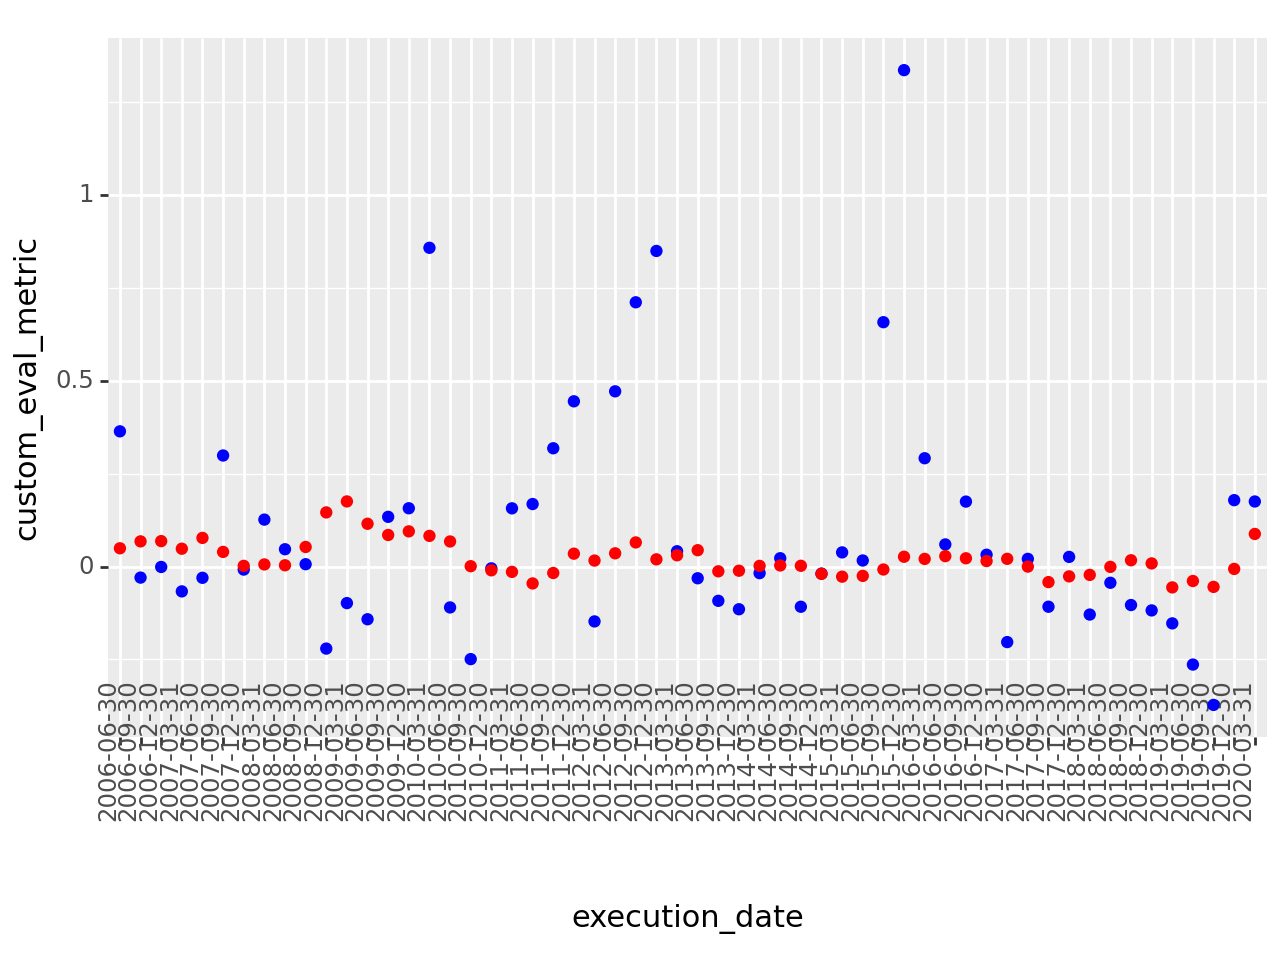

<Figure Size: (640 x 480)>

In [33]:
(
    ggplot(
        test_results_final_tree[test_results_final_tree["custom_eval_metric"] < 10],
        aes(x="execution_date"),
    )
    + geom_point(aes(y="custom_eval_metric"), colour="blue")
    + geom_point(aes(y="diff_ch_sp500_baseline"), colour="red")
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)

In [34]:
print(f"Mean for model: {test_results_final_tree['custom_eval_metric'].mean()}")
print(
    f"Mean for baseline: {test_results_final_tree['diff_ch_sp500_baseline'].mean()}\n"
)

print(f"Median for model: {test_results_final_tree['custom_eval_metric'].median()}")
print(
    f"Median for baseline: {test_results_final_tree['diff_ch_sp500_baseline'].median()}\n"
)

Mean for model: 0.09278869642857143
Mean for baseline: 0.022159133577893696

Median for model: 0.011363999999999999
Median for baseline: 0.015525563344158869



## Conclusions

**Mean and Median Analysis: Model vs. Baseline**.
The mean value of your model stands at approximately 9.28%, significantly higher than the baseline's mean of about 2.22%. This indicates that on average, your model predicts considerably higher returns compared to the baseline. However, when looking at the median values, a different picture emerges. The model's median is around 1.14%, lower than the baseline's 1.55%. This suggests that while the model excels in generating higher average returns, its performance across various scenarios is less consistent, as the median is more resistant to outliers than the mean.

**High-level and low-level Metrics Approach**. In terms of metrics, we've adopted a dual approach. At the high level, we focused on overarching performance indicators like yearly returns compared to benchmarks like the SP500, assessing the general effectiveness of the model. At the low level, we concentrated on detailed aspects such as variable importance and median performance, which offer insights into the model's behavior in typical scenarios and its resilience to extreme cases. This combination of high-level and low-level analysis provides a comprehensive view, highlighting the model's strong average performance and areas for potential refinement.


1. **Model Performance Improvement**: Enhanced predictive capabilities with reduced validation error, showing improved performance compared to the `diff_ch_sp500_baseline`.
2. **Risk Management and Variable Importance**: Increased robustness and reduced overfitting by addressing data leakage issues, leading to better risk handling by eliminating reliance on misleading variables.
3. **Mean Performance Values**: Significant improvement in final mean values over the initial baseline, with the model outperforming the SP500 on average after refinements.
4. **High-Risk, High-Reward Strategy**: Adoption of a strategy with higher risks but potentially higher rewards, capable of achieving exceptional results in certain periods, indicating a riskier approach.
5. **Potential Areas for Future Improvement**:
    - Exploration of different `n_quarters` variables for temporal trend analysis and optimization of the `top_n` parameter could further balance risk and reward. Additionally, other algorithm for optimising this selection might be worth to explore.
    - Temporal Trend Analysis: Deepening the investigation into different n_quarters variables to better understand and capture market cycles.
    - Optimization of Investment Strategies: Fine-tuning the top_n parameter to improve risk-adjusted returns and balance investment strategies.
    - Variable Selection and Data Leakage: Continual refinement in variable selection to prevent data leakage, thereby enhancing the model's robustness.
    - Handling Stock Splits and Outliers: Implementing strategies to adjust for stock splits and outliers, instead of eliminating such stocks, to maintain data integrity and model effectiveness (e.g. delete only suspicious high price tickers, manage to get price-adjusted stock split, etc).
    - Exploring Alternative Algorithms: Testing various algorithms for optimizing stock selection, focusing on those better suited for financial data complexities.
    - Exploring Advanced Train-Test Splitting Methods: Investigating more sophisticated approaches for dividing data into training and testing sets to enhance the model's ability to generalize to unseen data, potentially incorporating techniques like time-series cross-validation or stratified splits based on market conditions.
    - Continuous Model Evaluation: Regularly updating and back-testing the model against current market trends to ensure its ongoing relevance and accuracy.
6. **Overall Reflection**: Successful transition to a higher level of abstraction in metrics, focusing on yearly returns compared to the SP500, acknowledging the complexity of financial modeling and the potential for ongoing optimization.

-- Now we're more than ready to be hired by Renaissance Tech or Two Sigma :D